# Introduction
Nous travaillons pour la ville de Seattle. Elle nous demande de l'aider pour atteindre son objectif de ville neutre en émissions de carbone en 2050.
Nous allons donc étudier de près la consommation et les émissions des bâtiments non destinés à l’habitation.

Puisque les relevés sont tres couteux,nous allons a partir des relevés déjà réalisées,  tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées.

Pour ce faire, nous allons:

*   Réaliser une courte analyse exploratoire.
*   Tester différents modèles de prédiction afin de répondre au mieux à la problématique et tenter d'améliorer leuur performances.




# Importation des librairies et chargement des données

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/2016_Building_Energy_Benchmarking.csv", sep=',')
df.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [ ]:
df.shape

(3376, 46)

Comme notre algorithme ne va predire que les batiments non destinés à l'habitation, alors on va selectionner que ces batiments

In [ ]:
non_residence=['NonResidential', 'Nonresidential COS', 'Nonresidential WA' ]
df=df[df['BuildingType'].isin(non_residence)]
df.shape

(1546, 46)

# Informations sur la base de données

In [ ]:
df['BuildingType'].unique()
df['PrimaryPropertyType'].unique()

array(['Hotel', 'Other', 'Mixed Use Property', 'University',
       'Small- and Mid-Sized Office', 'Self-Storage Facility',
       'Warehouse', 'K-12 School', 'Large Office',
       'Senior Care Community', 'Medical Office', 'Retail Store',
       'Hospital', 'Residence Hall', 'Distribution Center',
       'Worship Facility', 'Supermarket / Grocery Store', 'Laboratory',
       'Refrigerated Warehouse', 'Restaurant', 'Low-Rise Multifamily',
       'Office'], dtype=object)

In [ ]:
df['Address'].unique()

array(['405 Olive way', '724 Pine street', '1900 5th Avenue', ...,
       '1920 1st Ave W', '8319 8th Ave S', '2820 S Myrtle St'],
      dtype=object)

In [ ]:
df.info(verbose=True), print(f'\n Nous avons {df.shape[0]} batiments et {df.shape[1]} caractéristiques')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1546 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1546 non-null   int64  
 1   DataYear                         1546 non-null   int64  
 2   BuildingType                     1546 non-null   object 
 3   PrimaryPropertyType              1546 non-null   object 
 4   PropertyName                     1546 non-null   object 
 5   Address                          1546 non-null   object 
 6   City                             1546 non-null   object 
 7   State                            1546 non-null   object 
 8   ZipCode                          1530 non-null   float64
 9   TaxParcelIdentificationNumber    1546 non-null   object 
 10  CouncilDistrictCode              1546 non-null   int64  
 11  Neighborhood                     1546 non-null   object 
 12  Latitude            

(None, None)

Affichage du graphe des differents types de données

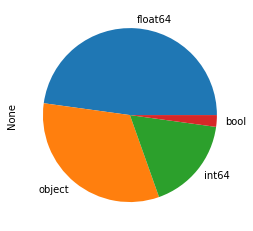

In [ ]:
df.dtypes.value_counts().plot(kind='pie')

Nous avons des variables booléennes, des objects, des entiers et des décimals

In [ ]:
#Les colonnes:
colonnes=list(df.columns)
df.shape

(1546, 46)

# Supression des colonnes inutiles

In [ ]:
df['TaxParcelIdentificationNumber'].dtypes

dtype('O')

In [ ]:
df['TaxParcelIdentificationNumber']=df['TaxParcelIdentificationNumber'].apply(lambda x : float(x.split("and")[0].split("-")[0]))
df['TaxParcelIdentificationNumber'].dtypes

dtype('float64')

In [ ]:
#Nous prenons seulement les batiments qui n'ont pas utilisés les valeurs par defaut pour au moins une de leur parcelles
df=df[df['DefaultData']==False]
df=df[df['ComplianceStatus']!='Missing Data']

In [ ]:
df.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

In [ ]:
df['DataYear'].unique(), df['State'].unique(), df['City'].unique(), df['DefaultData'].unique()

(array([2016]),
 array(['WA'], dtype=object),
 array(['Seattle'], dtype=object),
 array([False]))

In [ ]:
#Colonnes inutiles
col_inu=['DefaultData','TaxParcelIdentificationNumber', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'CouncilDistrictCode', 'OSEBuildingID', 'DataYear','City',
 'State', 'GHGEmissionsIntensity','NumberofBuildings','SiteEUI(kBtu/sf)',
 'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)','Electricity(kWh)',
 'NaturalGas(therms)', 'ListOfAllPropertyUseTypes','SecondLargestPropertyUseType','ThirdLargestPropertyUseType', 'PropertyName']

In [ ]:
df.drop(columns=col_inu, inplace=True)
df.columns

Index(['BuildingType', 'PrimaryPropertyType', 'Address', 'ZipCode',
       'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofFloors',
       'PropertyGFATotal', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'Comments',
       'ComplianceStatus', 'Outlier', 'TotalGHGEmissions'],
      dtype='object')

# Valeurs manquantes




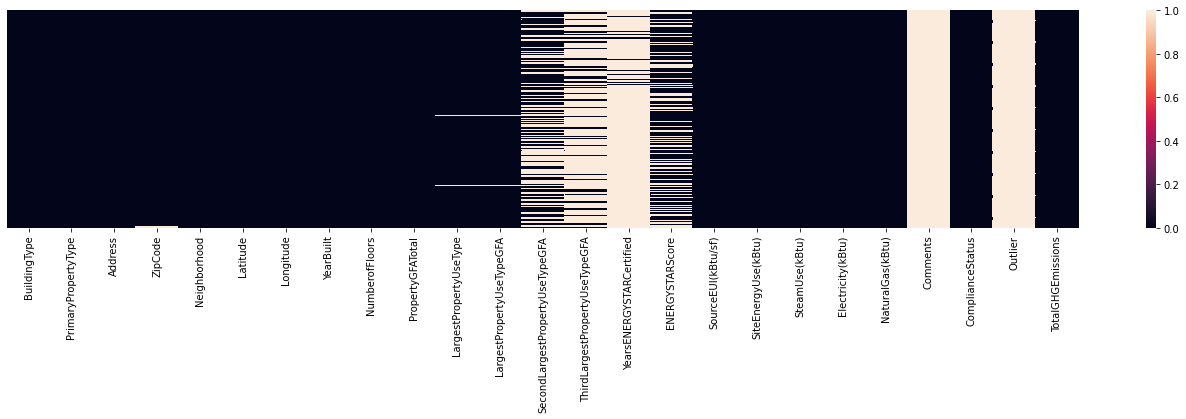

In [ ]:
plt.figure(figsize=(24,4))
sns.heatmap(data=df.isnull(), yticklabels=False)

Construisons un tableau qui nous montre le pourcentage des valeurs manquantes

In [ ]:
df.isnull().sum(axis=0)/df.shape[1]
col1=list(df.isnull().sum(axis=0)*100/df.shape[0])
nan_df=pd.DataFrame(col1, columns=['Nan_percent'])
nan_df["colonnes"]=list(df.columns)
nan_df=nan_df.sort_values(by='Nan_percent', ascending=False)
nan_df.head(8)


,Nan_percent,colonnes
21,100.000000,Comments
23,99.020888,Outlier
14,94.060052,YearsENERGYSTARCertified
13,77.676240,ThirdLargestPropertyUseTypeGFA
12,45.430809,SecondLargestPropertyUseTypeGFA
15,35.182768,ENERGYSTARScore
3,0.848564,ZipCode
10,0.391645,LargestPropertyUseType


Les valeurs manquantes qui ont au moins jusqu"a plus de 50% de valeurs manquantes sont

In [ ]:
a=list(nan_df.loc[nan_df['Nan_percent']>50, "colonnes"].values)
nan_col=[i for i in a if i!="Outlier"]

Apart les Outliers, les autres colonnes ne sont pas trop importantes aussi au prédiction on va les supprimer

In [ ]:
df.drop(columns=nan_col, inplace=True)

Nous allons créer une autre catégorie par rapport d'Outliers qui serra la categorie 'normale'

In [ ]:
df.loc[df['Outlier'].isnull(), 'Outlier']="Normal"

Puisque la variables energyscore est tres importante dans notre étude, nous allons garder les lignes qui comportent un energy score

In [ ]:
df1=df[df['ENERGYSTARScore'].notna()]
df1.shape, df.shape

((993, 22), (1532, 22))

On remplace les valeurs manquantes de type int et float par leur valeur median  , puis celles de types object par les valeurs les plus frequentes.

In [ ]:
for col in list(df.columns):
  if df[col].dtypes in ['float64', 'int32']:
    df[col].fillna(df[col].median(), inplace=True)
  else:
    df[col].fillna(str(df[col].mode()[0]), inplace=True)
df.isnull().sum()

BuildingType                       0
PrimaryPropertyType                0
Address                            0
ZipCode                            0
Neighborhood                       0
Latitude                           0
Longitude                          0
YearBuilt                          0
NumberofFloors                     0
PropertyGFATotal                   0
LargestPropertyUseType             0
LargestPropertyUseTypeGFA          0
SecondLargestPropertyUseTypeGFA    0
ENERGYSTARScore                    0
SourceEUI(kBtu/sf)                 0
SiteEnergyUse(kBtu)                0
SteamUse(kBtu)                     0
Electricity(kBtu)                  0
NaturalGas(kBtu)                   0
ComplianceStatus                   0
Outlier                            0
TotalGHGEmissions                  0
dtype: int64

In [ ]:
for col in list(df.columns):
  if df1[col].dtypes in ['float64', 'int32']:
    df1[col].fillna(df1[col].median(), inplace=True)
  else:
    df1[col].fillna(str(df1[col].mode()[0]), inplace=True)
df1.isnull().sum()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inpla

BuildingType                       0
PrimaryPropertyType                0
Address                            0
ZipCode                            0
Neighborhood                       0
Latitude                           0
Longitude                          0
YearBuilt                          0
NumberofFloors                     0
PropertyGFATotal                   0
LargestPropertyUseType             0
LargestPropertyUseTypeGFA          0
SecondLargestPropertyUseTypeGFA    0
ENERGYSTARScore                    0
SourceEUI(kBtu/sf)                 0
SiteEnergyUse(kBtu)                0
SteamUse(kBtu)                     0
Electricity(kBtu)                  0
NaturalGas(kBtu)                   0
ComplianceStatus                   0
Outlier                            0
TotalGHGEmissions                  0
dtype: int64

In [ ]:
print(f'nous avons {df.shape[0]} observations et {df.shape[1] } caractéristiques')

nous avons 1532 observations et 22 caractéristiques


In [ ]:
df.isnull().sum()

BuildingType                       0
PrimaryPropertyType                0
Address                            0
ZipCode                            0
Neighborhood                       0
Latitude                           0
Longitude                          0
YearBuilt                          0
NumberofFloors                     0
PropertyGFATotal                   0
LargestPropertyUseType             0
LargestPropertyUseTypeGFA          0
SecondLargestPropertyUseTypeGFA    0
ENERGYSTARScore                    0
SourceEUI(kBtu/sf)                 0
SiteEnergyUse(kBtu)                0
SteamUse(kBtu)                     0
Electricity(kBtu)                  0
NaturalGas(kBtu)                   0
ComplianceStatus                   0
Outlier                            0
TotalGHGEmissions                  0
dtype: int64

In [ ]:
df.loc[df["Outlier"].notna(), 'Outlier']

0       Normal
1       Normal
2       Normal
3       Normal
4       Normal
         ...  
3370    Normal
3372    Normal
3373    Normal
3374    Normal
3375    Normal
Name: Outlier, Length: 1532, dtype: object

In [ ]:
df1.shape, df.shape

((993, 22), (1532, 22))

# Feature Enginering

## Traitement des variables

Nous allons connaitre plutot la recence du batiment

In [ ]:
df['YearBuilt']=2016-df['YearBuilt']
df1['YearBuilt']=2016-df1['YearBuilt']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df.shape

(1532, 22)

In [ ]:
df['YearBuilt'].unique()

array([ 89,  20,  47,  90,  36,  17, 112,  18,  88,  94,  12,  86,  33,
       109, 100,  31,  15,  25,  38, 110,  22,  61,  55, 116,  62, 105,
        43,  96, 106,  34, 108,  57,  16,  19,  54,  46,   8,  51,  87,
         6,  26,  78,  30,  14,  93,  13,  75,  10, 101,  66,  58,   7,
        45,   9,  65,  52,  63,  79,  50,  59,  48,  92,  11,  85,  44,
        64, 102, 103,  35,  27,  91,  40, 107,  28,  37,  69,  32,  60,
       104,  39,  56,  71,  24,  53,  42,  41,  70,  21,  49,  29,  67,
        76,  84,  68,  23,  98, 111, 114,  95,  77,  72,  99,  74, 113,
         4,   3,  97, 115,  80,  81,   5,   2,   1])

In [ ]:
'''df['state']= 'Address', 'ZipCode',
   , 'Neighborhood', 'Latitude', 'Longitude','''

"df['state']= 'Address', 'ZipCode',\n   , 'Neighborhood', 'Latitude', 'Longitude',"

In [ ]:
df['Neighborhood'].unique()

array(['DOWNTOWN', 'NORTHEAST', 'EAST', 'LAKE UNION', 'GREATER DUWAMISH',
       'BALLARD', 'NORTHWEST', 'MAGNOLIA / QUEEN ANNE', 'CENTRAL',
       'SOUTHWEST', 'SOUTHEAST', 'NORTH', 'DELRIDGE', 'North', 'Delridge',
       'Ballard', 'Northwest', 'Central', 'DELRIDGE NEIGHBORHOODS'],
      dtype=object)

In [ ]:

df['Electricity(kBtu)']=df['Electricity(kBtu)']/df['Electricity(kBtu)'].sum()
df['SteamUse(kBtu)']=df['SteamUse(kBtu)']/df['SteamUse(kBtu)'].sum()
df['NaturalGas(kBtu)']=df['NaturalGas(kBtu)']/df['NaturalGas(kBtu)'].sum()

df1['Electricity(kBtu)']=df1['Electricity(kBtu)']/df1['Electricity(kBtu)'].sum()
df1['SteamUse(kBtu)']=df1['SteamUse(kBtu)']/df1['SteamUse(kBtu)'].sum()
df1['NaturalGas(kBtu)']=df1['NaturalGas(kBtu)']/df1['NaturalGas(kBtu)'].sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

## Correlation entre les variables

In [ ]:
df.columns

Index(['BuildingType', 'PrimaryPropertyType', 'Address', 'ZipCode',
       'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofFloors',
       'PropertyGFATotal', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
       'ComplianceStatus', 'Outlier', 'TotalGHGEmissions'],
      dtype='object')

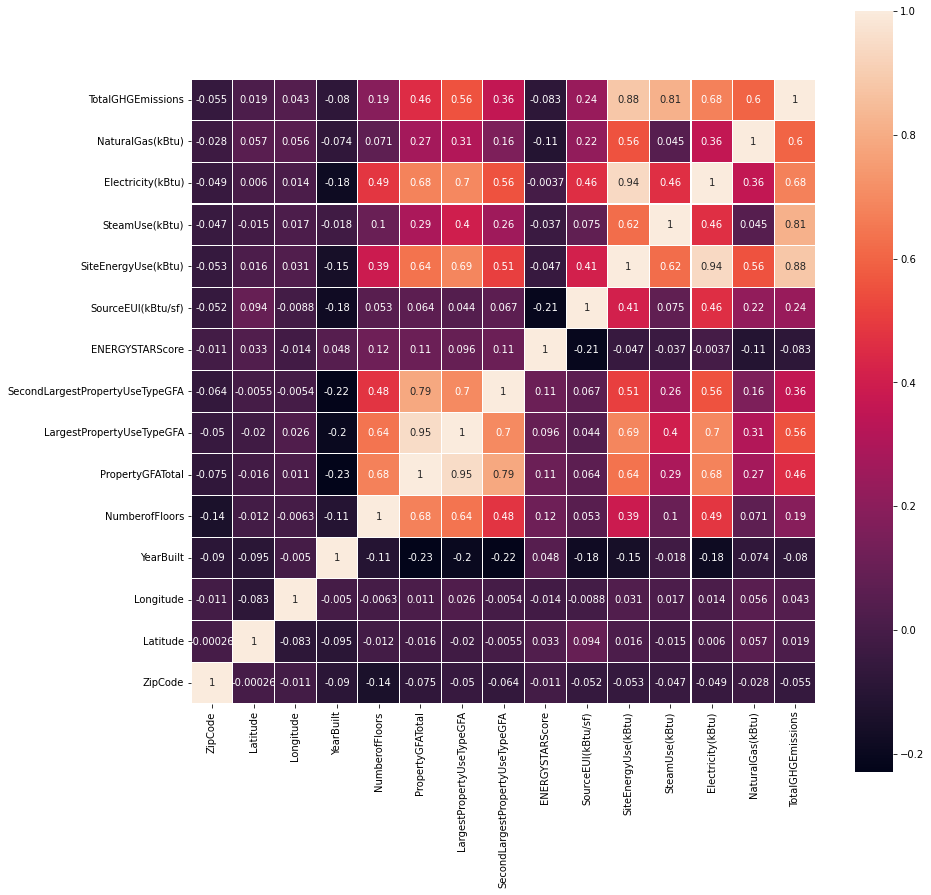

In [ ]:
corr_matrix = df[[i for i in df.columns]].corr()
fig = plt.figure(1, figsize=(14, 14))

sns.heatmap(corr_matrix, square=True, linewidths=0.1, annot=True)
plt.xlim(0, corr_matrix.shape[1])
plt.ylim(0, corr_matrix.shape[0])
plt.show()

Nous observons ici:
*'SecondLargestPropertyUseTypeGFA et le LargestPropertyUseTypeGFA sont tres correllés à 'PropertyGFATotal', Nous allons les supprimer




In [ ]:
corr_var=['SecondLargestPropertyUseTypeGFA','LargestPropertyUseTypeGFA' ]
df.drop(columns=corr_var, inplace=True)
df1.drop(columns=corr_var, inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df.shape

(1532, 20)

Il n'y a que 13 lignes qui ont utilisés les données par defaut

Cette variable indique si une propriété a satisfait aux exigences d'analyse comparative énergétique pour l'année de déclaration en cours. On va donc l'encoder en donnant plus d'importance aux observations satisfaisant à la condition

In [ ]:
df['ComplianceStatus'].unique()

array(['Compliant', 'Non-Compliant'], dtype=object)

In [ ]:
def compliance(x):
  if x=='Compliant':
    x=2
  else:
    x=0
  return x
df['ComplianceStatus']=df['ComplianceStatus'].apply(compliance)
df1['ComplianceStatus']=df1['ComplianceStatus'].apply(compliance)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


En observant de nouveau la correlation, nous avons

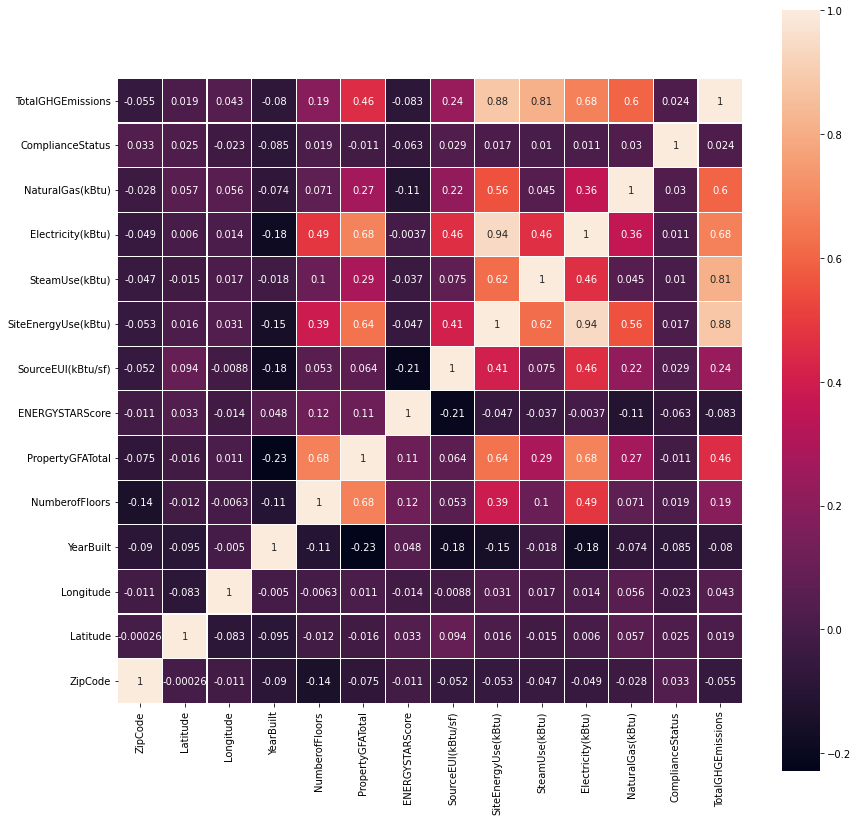

In [ ]:
corr_matrix = df.corr()
fig = plt.figure(1, figsize=(14, 14))

sns.heatmap(corr_matrix, square=True, linewidths=0.1, annot=True)
plt.xlim(0, corr_matrix.shape[1])
plt.ylim(0, corr_matrix.shape[0])
plt.show()

# Traitement des doublons

In [ ]:
doublons=df[['Latitude','Longitude', 'YearBuilt', 'ZipCode','Address']].duplicated().sum()
print(f'Nous avons {doublons} qui ont la meme adresse, meme longitude, meme latitude, meme année de construction, meme numéros de construction. \n nousallons donc les supprimer')

Nous avons 7 qui ont la meme adresse, meme longitude, meme latitude, meme année de construction, meme numéros de construction. 
 nousallons donc les supprimer


In [ ]:
doublons1=df1[['Latitude','Longitude', 'YearBuilt', 'ZipCode','Address']].duplicated().sum()
print(f'Nous avons {doublons1} qui ont la meme adresse, meme longitude, meme latitude, meme année de construction, meme numéros de construction. \n nousallons donc les supprimer')

Nous avons 5 qui ont la meme adresse, meme longitude, meme latitude, meme année de construction, meme numéros de construction. 
 nousallons donc les supprimer


In [ ]:
df.drop_duplicates(subset=['Latitude','Longitude', 'YearBuilt', 'ZipCode','Address'],inplace=True)
df1.drop_duplicates(subset=['Latitude','Longitude', 'YearBuilt', 'ZipCode','Address'],inplace=True)
df.shape, df1.shape

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


((1525, 20), (988, 20))

# Traitement des valeurs aberrantes

In [ ]:
df['ComplianceStatus']=df['ComplianceStatus'].astype('object')
targets=['SiteEnergyUse(kBtu)','TotalGHGEmissions' ]

In [ ]:
quan=[col for col in df.columns if df[col].dtypes in ['float64', 'int64']]
quan=[col for col in quan if col not in targets]
qual=[col for col in df.columns if df[col].dtypes=='object']
len(quan), len(qual), df.shape

(11, 7, (1525, 20))

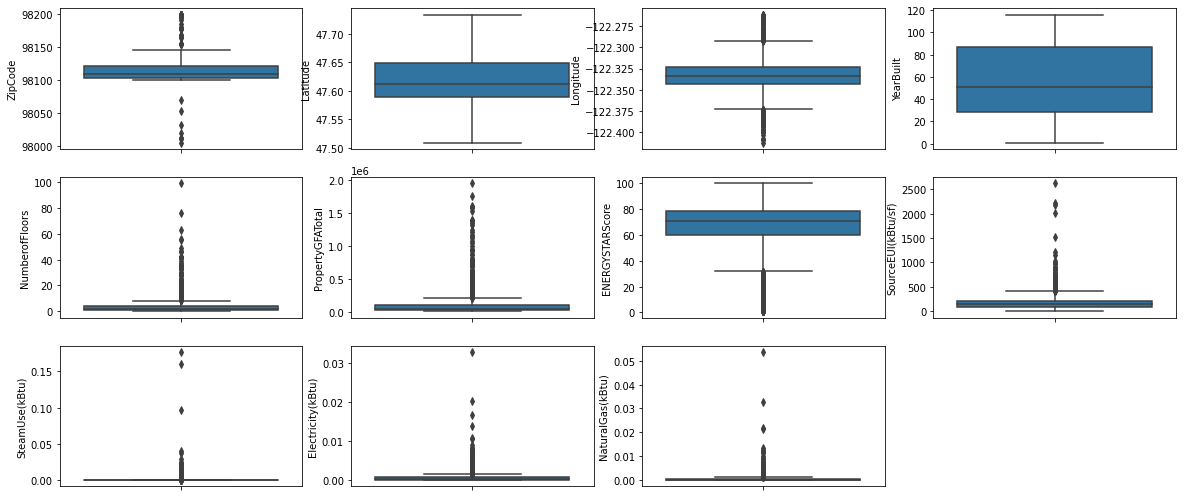

In [ ]:
fig = plt.figure(1, figsize=(20, 15))
for i,col in enumerate(quan) :
    plt.subplot(5,4,i+1)
    sns.boxplot(y=col, data=df)
plt.show()

La variable comme 'SourceEUI'  comportent des valeurs négatives. On va les éliminer. Bien que ce ne sont pas des valeurs anormales(des batiments qui fournissent de l'enrgie), ces valeurs vont reduire la précision de notre modele.

In [ ]:
df.columns

Index(['BuildingType', 'PrimaryPropertyType', 'Address', 'ZipCode',
       'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofFloors',
       'PropertyGFATotal', 'LargestPropertyUseType', 'ENERGYSTARScore',
       'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'ComplianceStatus', 'Outlier',
       'TotalGHGEmissions'],
      dtype='object')

In [ ]:
df=df[(df['SourceEUI(kBtu/sf)']>0)]
df1=df1[(df1['SourceEUI(kBtu/sf)']>0)]
df.shape

(1522, 20)

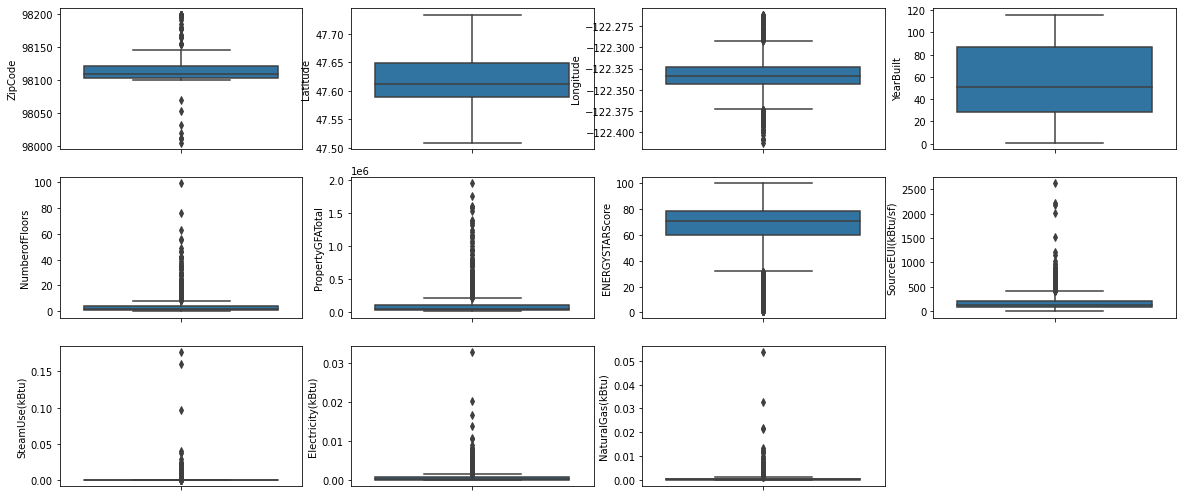

In [ ]:
fig = plt.figure(1, figsize=(20, 15))
for i,col in enumerate(quan) :
    plt.subplot(5,4,i+1)
    sns.boxplot(y=col, data=df)
plt.show()

Toutes les autres valeurs apparement aberrantes sont possibles, mais cela entrainera un mauvais fonctionnement de notre modele. Nous allons corriger cela plus tard par le passage au log et le standard scaling

## Observation du champ outlier

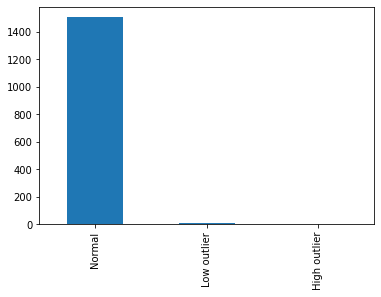

In [ ]:
df["Outlier"].value_counts().plot(kind="bar")

Nous n'allons garder que les observations à valeur normales

In [ ]:
df=df[df["Outlier"]=="Normal"]
df1=df1[df1["Outlier"]=="Normal"]
df.shape

(1507, 20)

Cette colonne devient donc inutile, puisqu'elle ne contient que la meme valeur

In [ ]:
df.drop(columns=['Outlier'], inplace=True)
df1.drop(columns=['Outlier'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df.columns

Index(['BuildingType', 'PrimaryPropertyType', 'Address', 'ZipCode',
       'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofFloors',
       'PropertyGFATotal', 'LargestPropertyUseType', 'ENERGYSTARScore',
       'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'ComplianceStatus',
       'TotalGHGEmissions'],
      dtype='object')

In [ ]:
quan=[col for col in df.columns if df[col].dtypes in ['float64', 'int64']]
quan=[col for col in quan if col not in targets]
qual=[col for col in df.columns if df[col].dtypes=='object']
len(quan), len(qual), df.shape

(11, 6, (1507, 19))

# Visualisation, analyse descriptive  et normalisation des variables

## Affichage des graphes des variables qualitatives

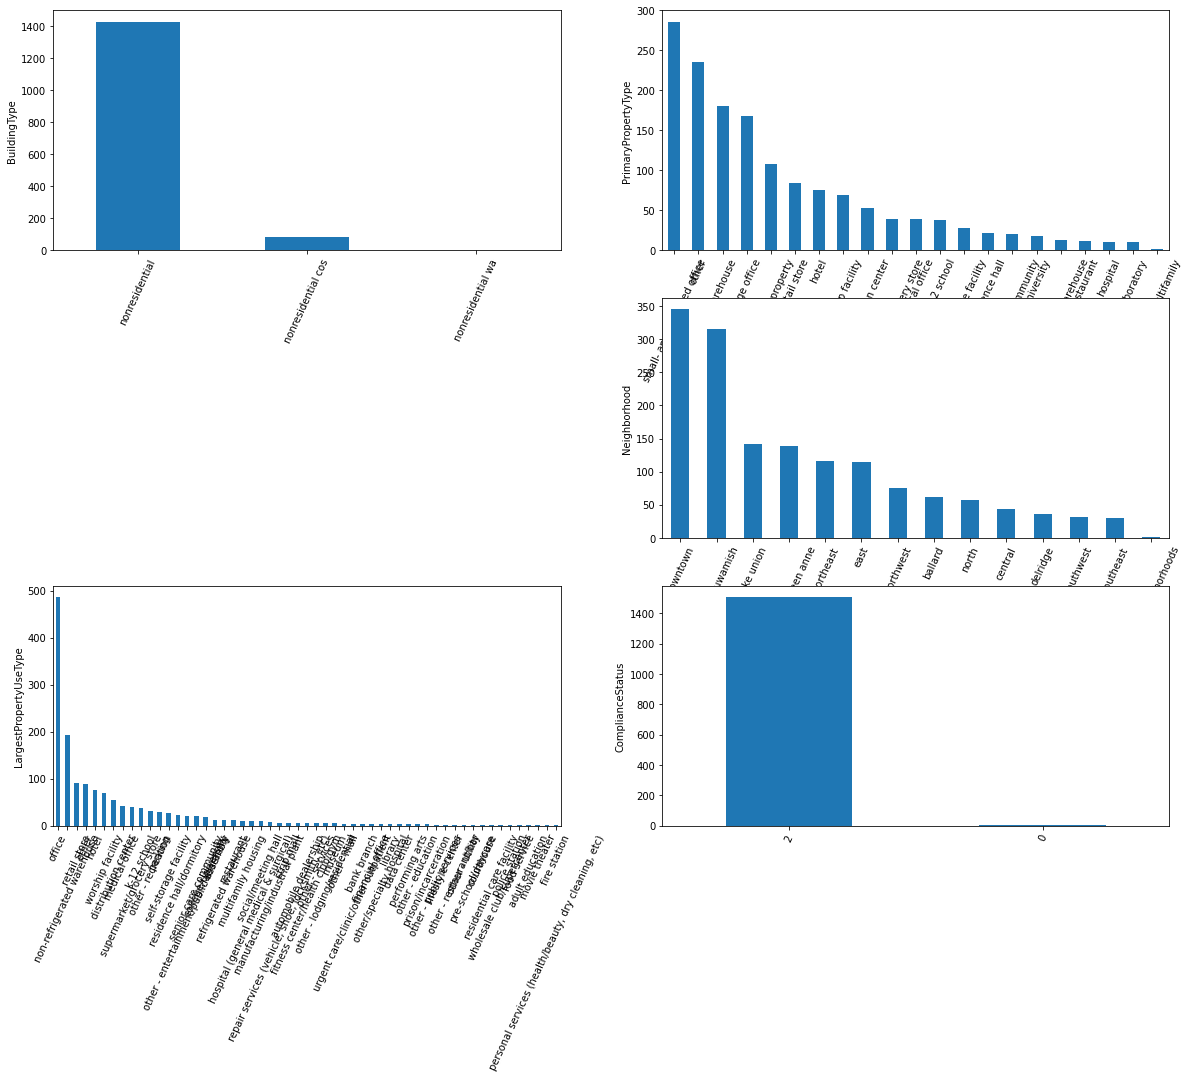

In [ ]:
fig = plt.figure(1, figsize=(20, 15))
for i,col in enumerate(qual) :
  try:
    if df[col].nunique()>60:
      pass
    else:
      plt.subplot(3,2,i+1)
      df[col].apply(lambda x: str(x).lower()).value_counts().plot(kind='bar')
      plt.ylabel(col)
      plt.xticks(rotation=65)
  except:
    pass
    #sns.histplot(x=col, data=df)
plt.show()

Les variables PrimaryPropertyType, et LargestPropertyUseType indiquent globalement des types de propriété

## Visualisation des targets

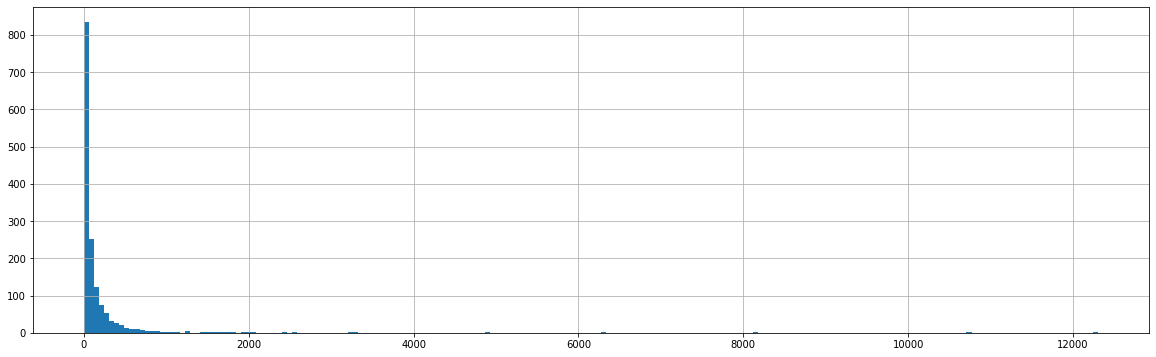

In [ ]:
plt.figure(figsize=(20, 6))
df['TotalGHGEmissions'].hist(bins=200)

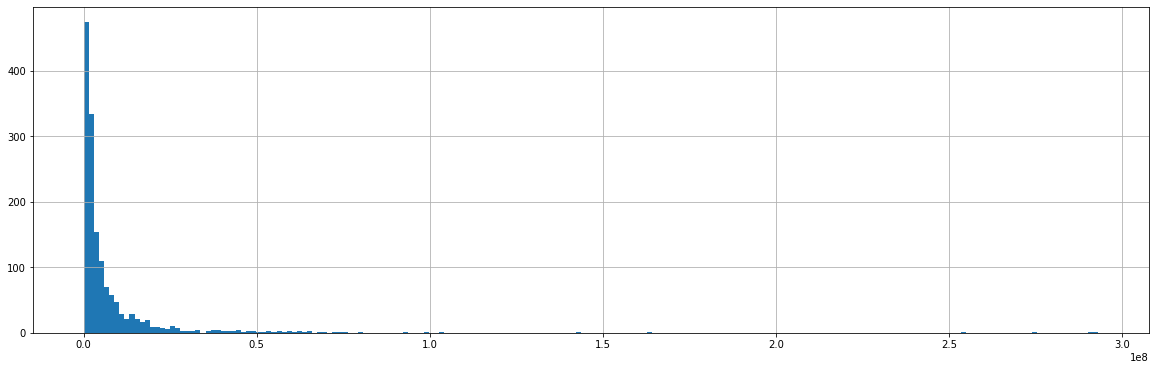

In [ ]:
plt.figure(figsize=(20, 6))
df['SiteEnergyUse(kBtu)'].hist(bins=200)

Les valeurs sont plus entre 0 et 0.5e8 pour le SiteEnergyUseWN de meme que pour le Total GHG Emission

## Variables quantitatives

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

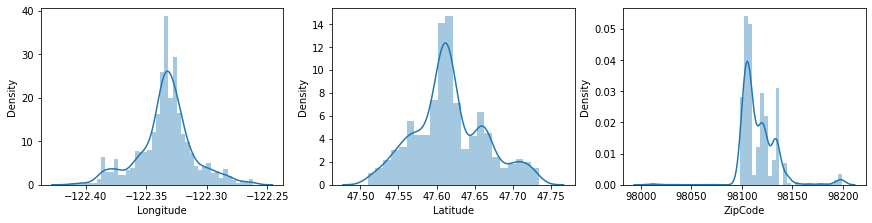

In [ ]:
fig = plt.figure(1, figsize=(20, 15))
liste=['Longitude', 'Latitude', 'ZipCode']
for i,col in enumerate(liste) :
    plt.subplot(4,4,i+1)
    try:
      sns.distplot(df[col])
    except:
      sns.distplot(np.isfinite(df[col]))
plt.show()

In [ ]:
quan=[i for i in df.columns if df[i].dtypes in ['float', 'int']]
quan1=['YearBuilt',
 'NumberofFloors', 'SteamUse(kBtu)',
 'Electricity(kBtu)',
 'NaturalGas(kBtu)',]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

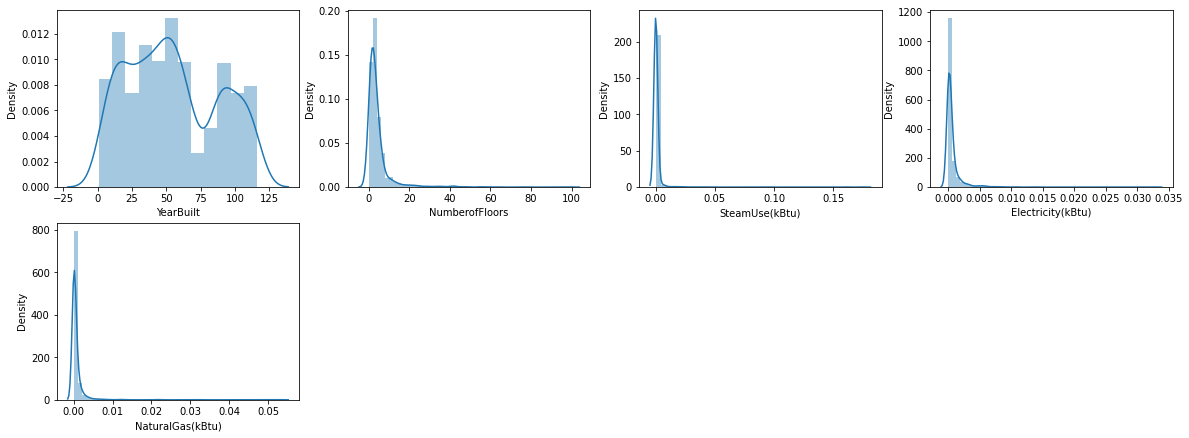

In [ ]:
fig = plt.figure(1, figsize=(20, 15))
for i,col in enumerate(quan1) :
    plt.subplot(4,4,i+1)
    try:
      sns.distplot(df[col])
    except:
      sns.distplot(np.isfinite(df[col]))
plt.show()

## Observons l'influence des variables sur les targets

## Influence de certaines variables sur le target

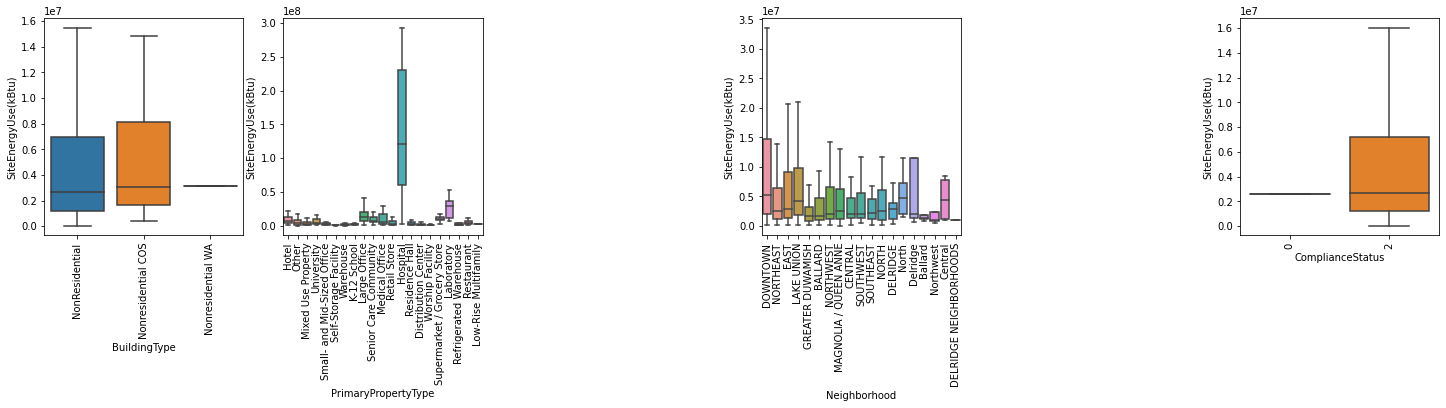

In [ ]:
fig = plt.figure(1, figsize=(25, 4))
for i,col in enumerate(qual) :
    if df[col].nunique()> 30:
      continue
    else:
      plt.subplot(1,6,i+1)
      sns.boxplot(data=df, x=col , y=targets[0], showfliers=False)
      plt.xticks(rotation=90)
    
plt.show()

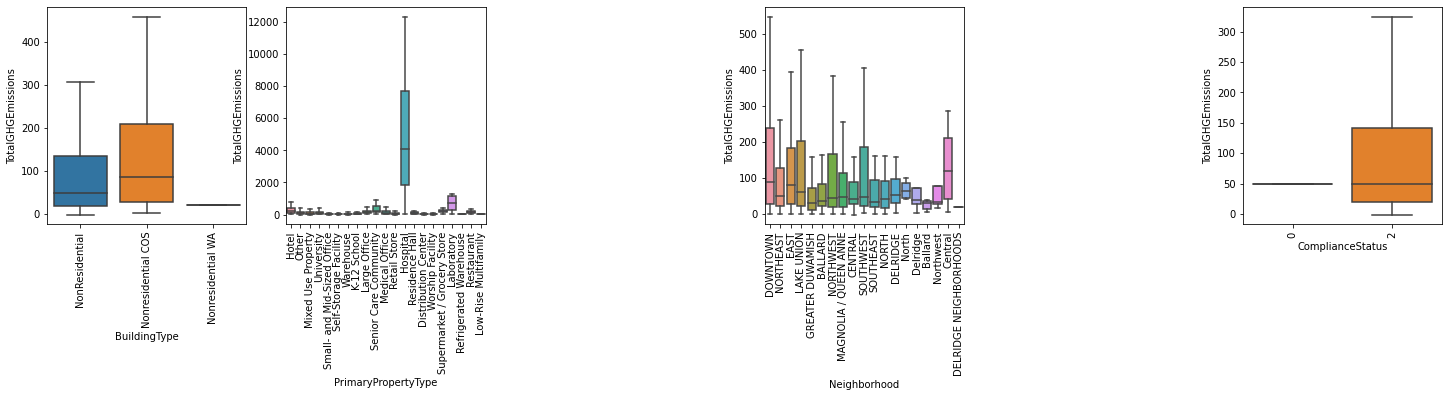

In [ ]:
fig = plt.figure(1, figsize=(25, 4))
for i,col in enumerate(qual) :
    if df[col].nunique()> 30:
      continue
    else:
      plt.subplot(1,6,i+1)
      sns.boxplot(data=df, x=col , y=targets[1], showfliers=False)
      plt.xticks(rotation=90)
    
plt.show()

Nous pouvons en deduire que 
* certaines villes utilisent plus d'energie et emmettent plus de C02 que d'autres: C'est le cas des capitales ou des villes dévéloppés(DOWNTOWN)
* Les hopitaux utilisent enormement d'energie et dégagent plus de CO2 que les autres imeubles


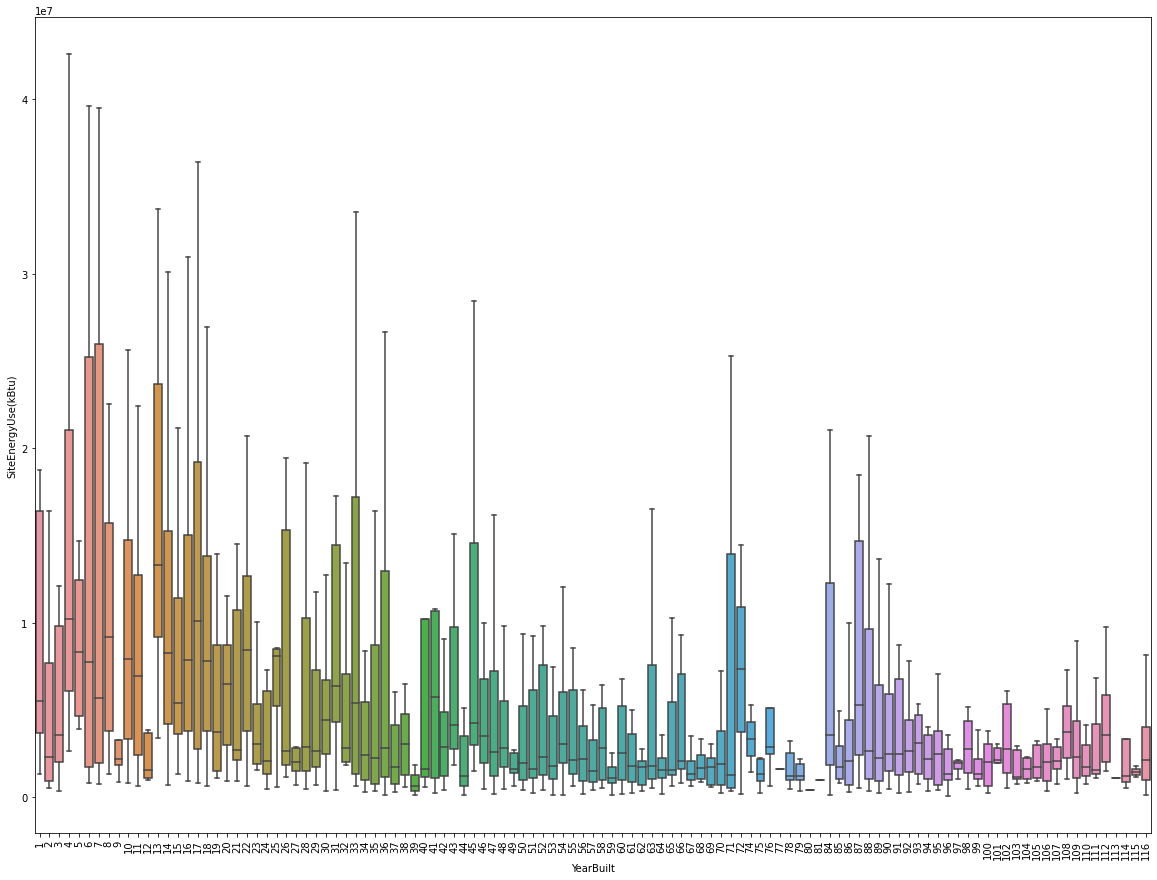

In [ ]:
fig = plt.figure(1, figsize=(20,15))
sns.boxplot(data=df, x='YearBuilt' , y=targets[0], showfliers=False)
plt.xticks(rotation=90)
plt.show()

les nouveaux batiments ont tendance à consommer plus d'energie que les anciennes

In [ ]:
qual1=[i for i in qual if df[i].nunique()<30]

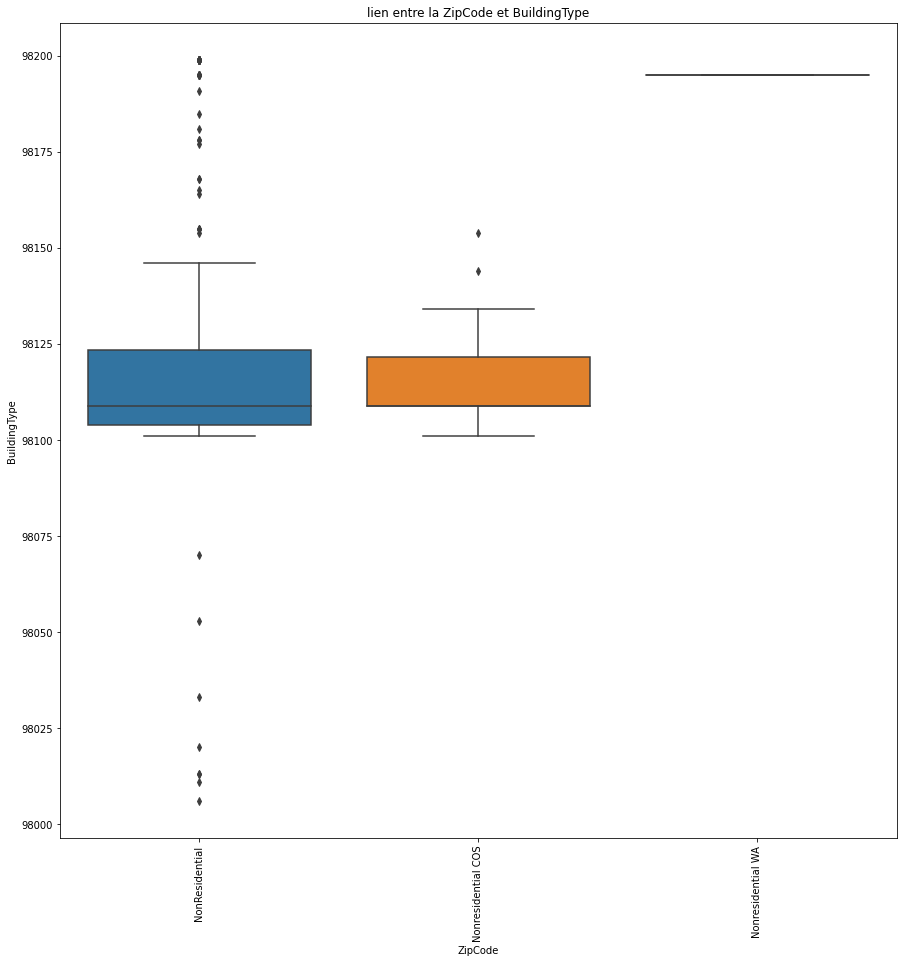

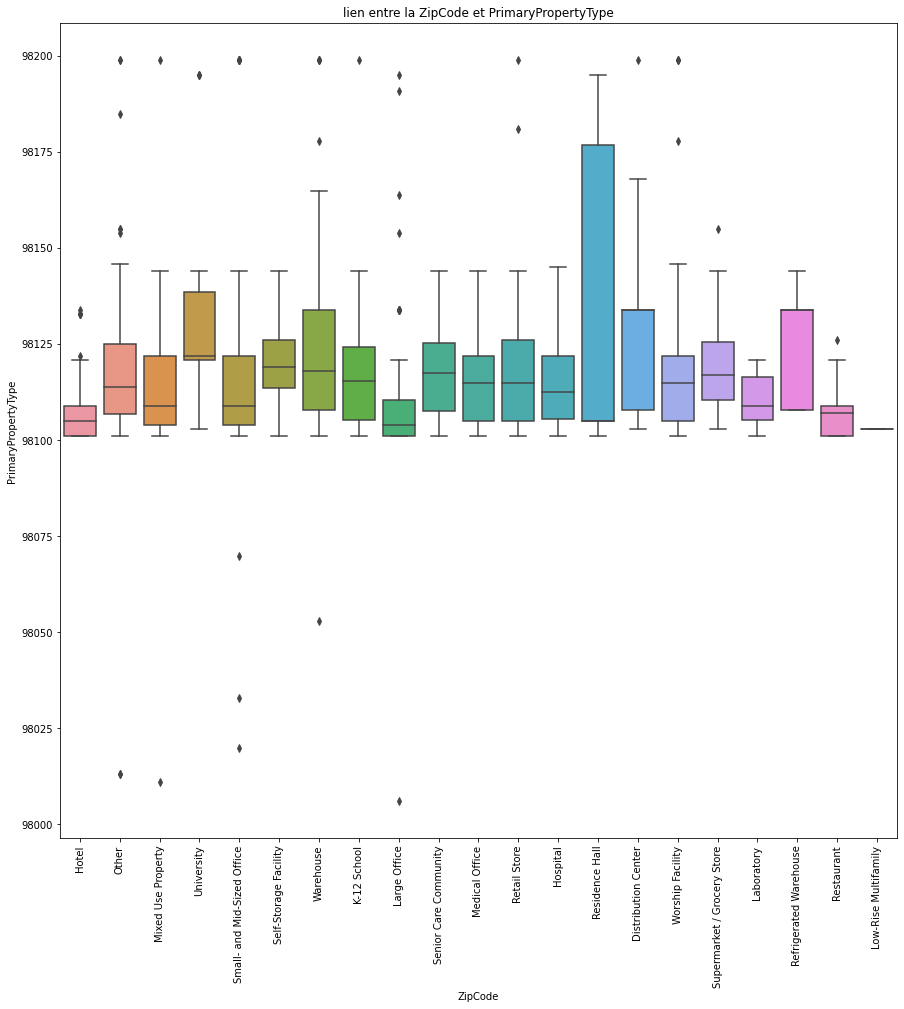

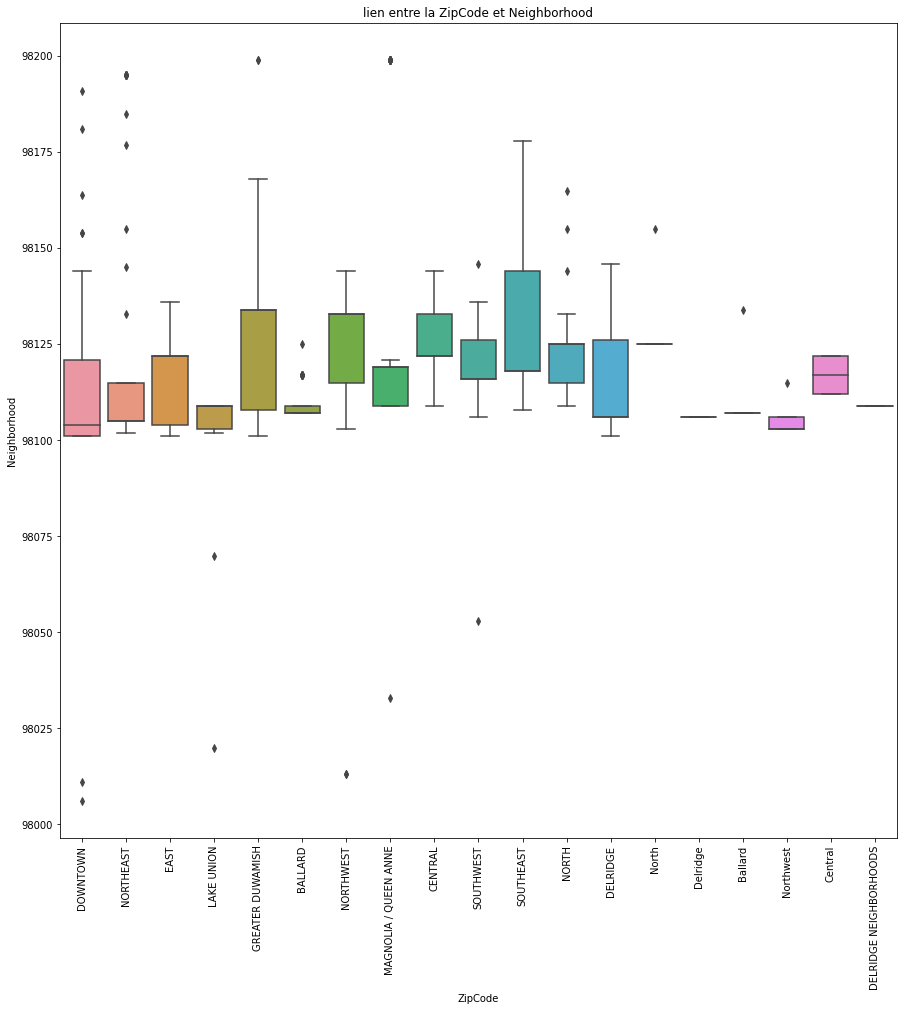

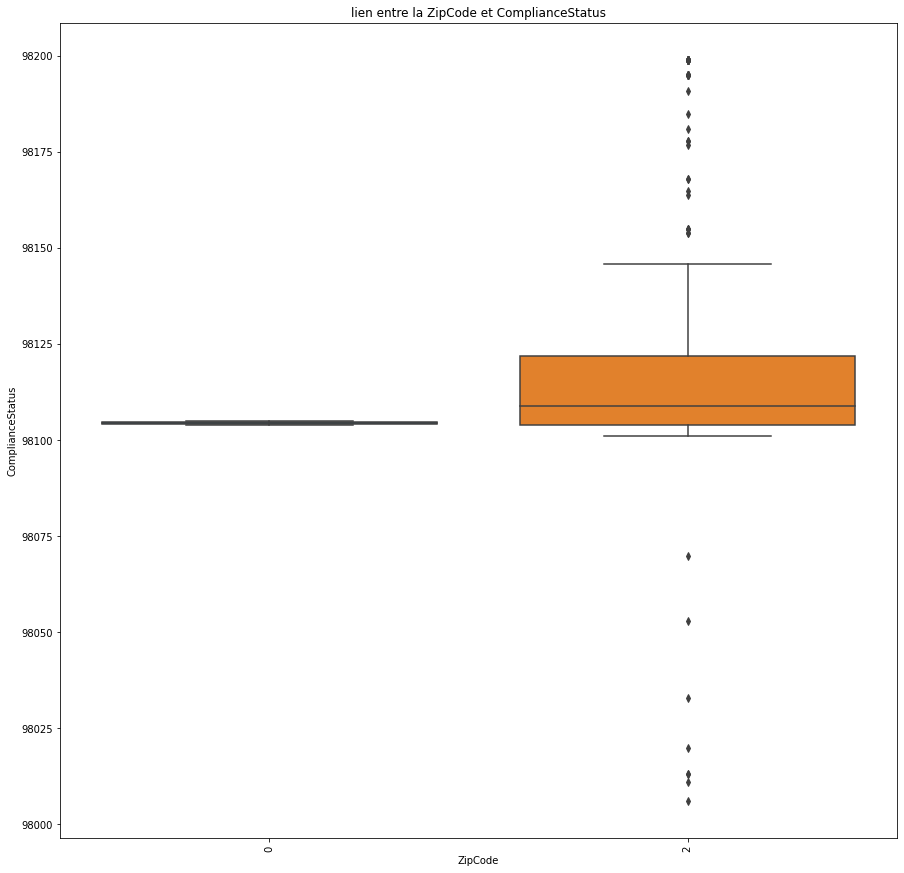

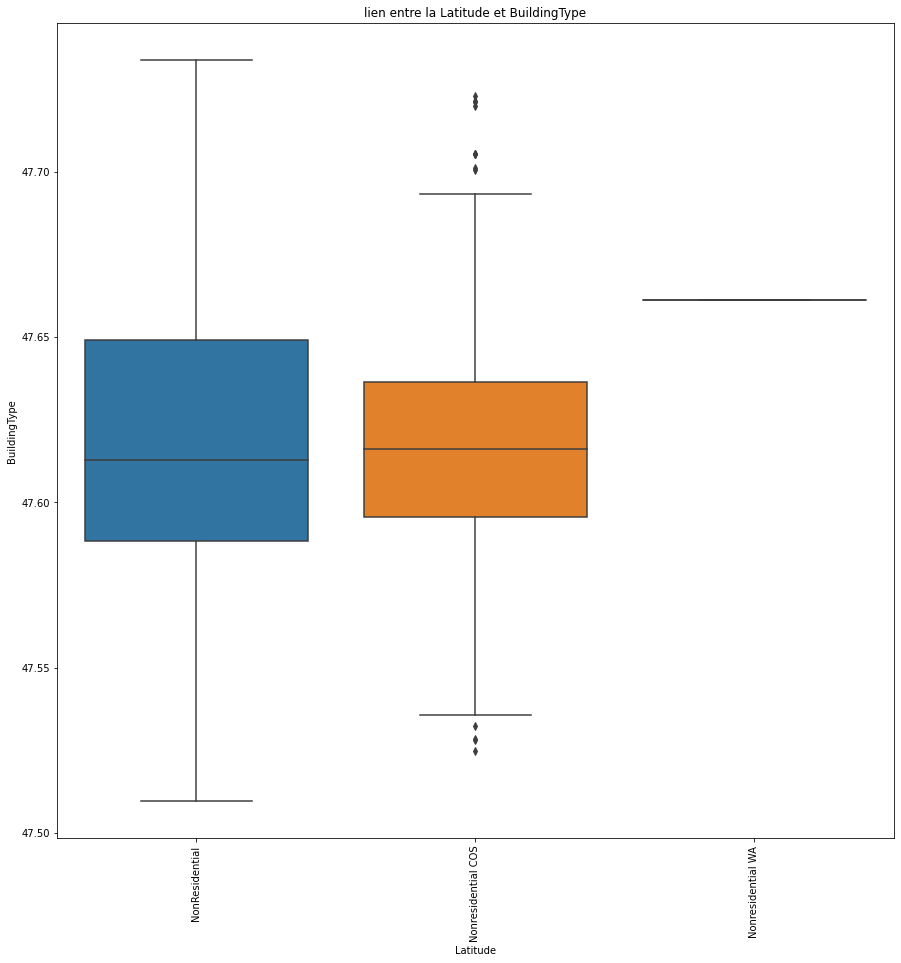

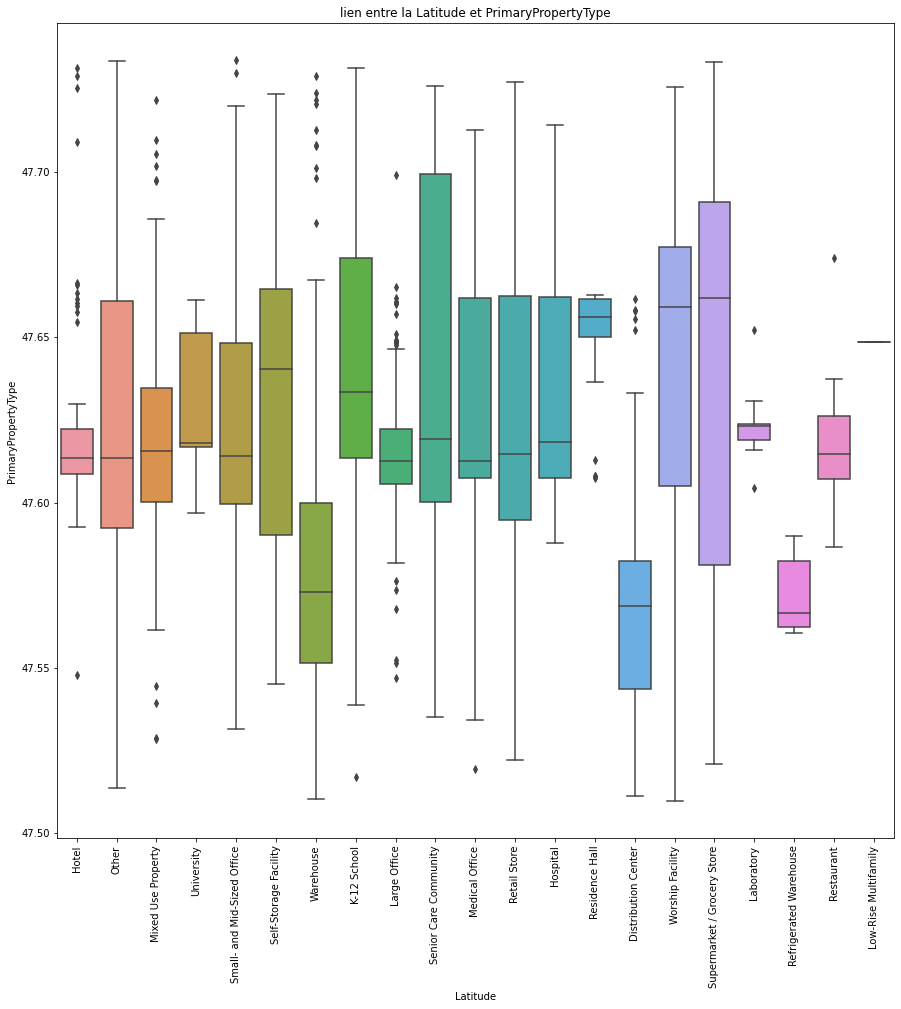

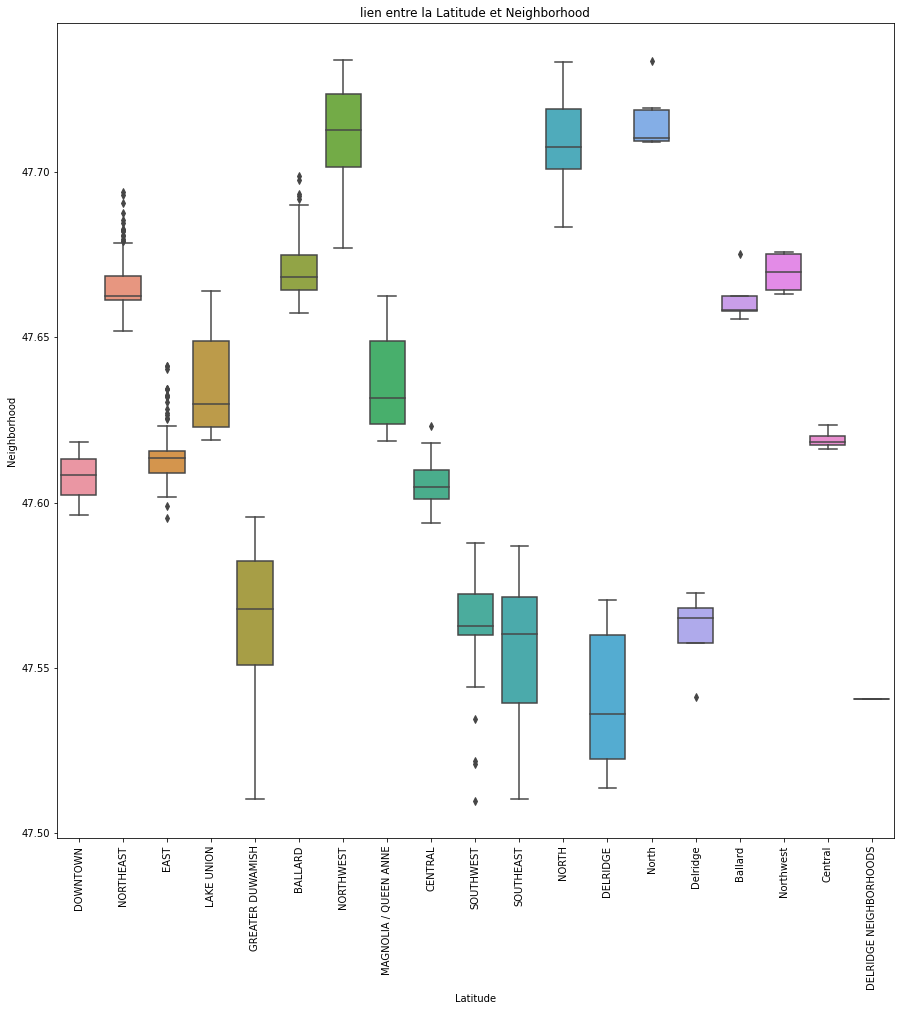

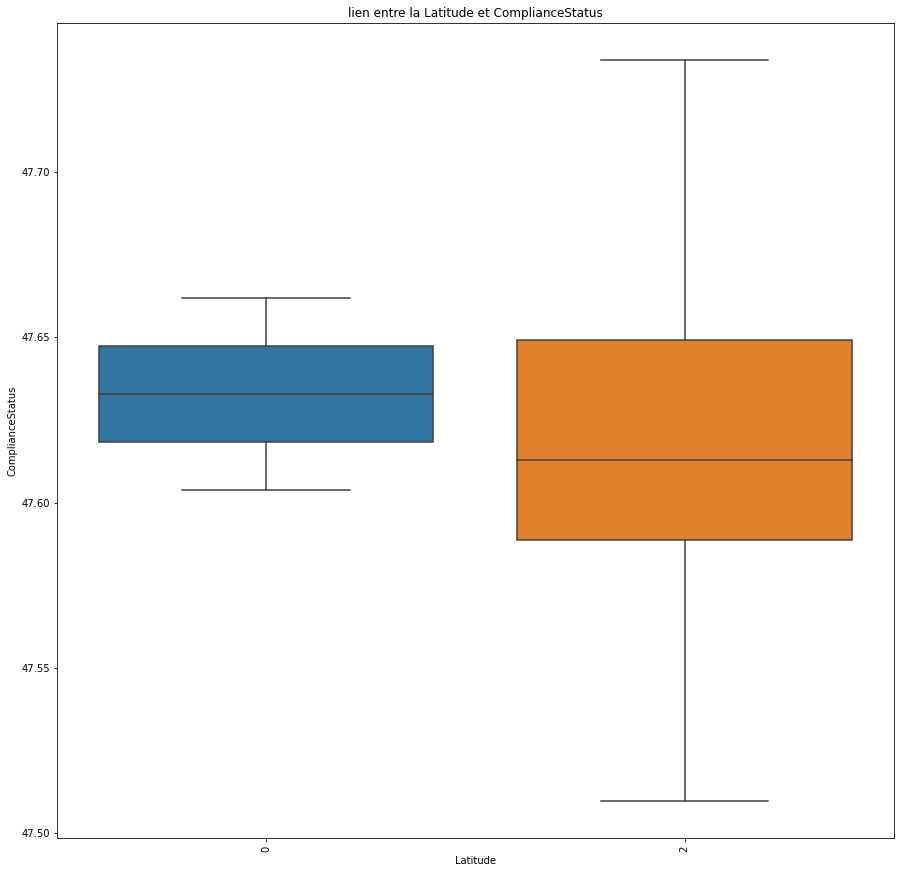

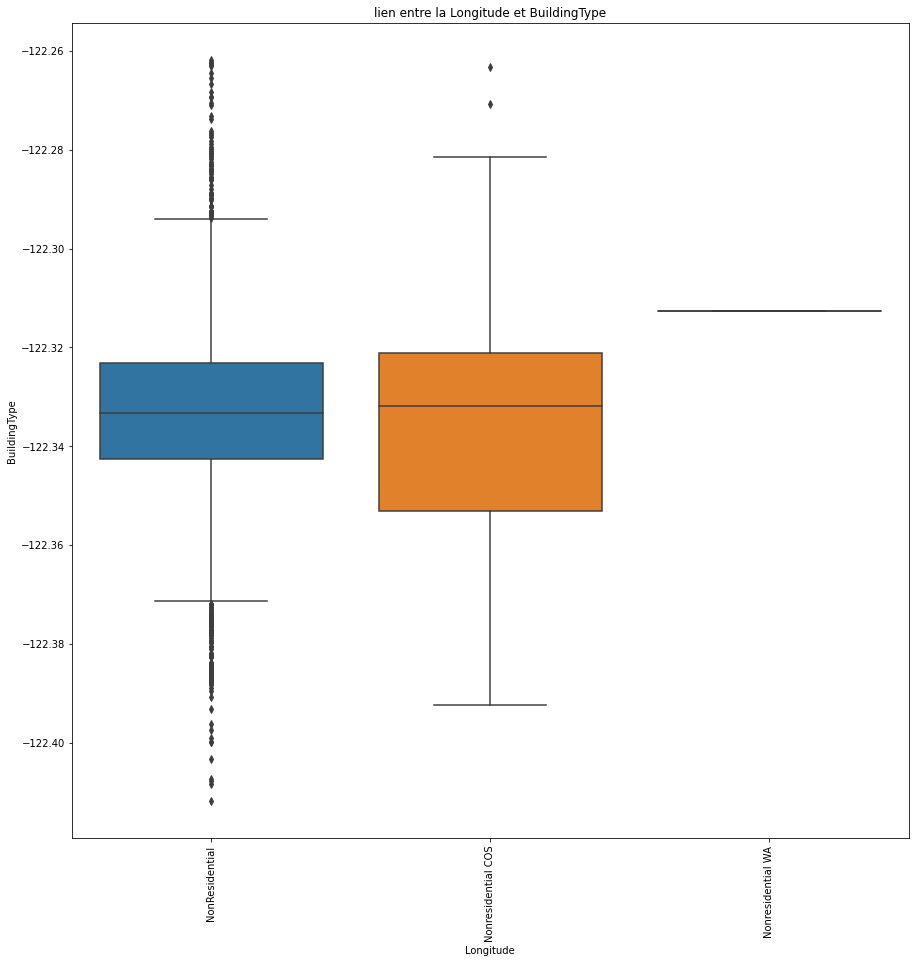

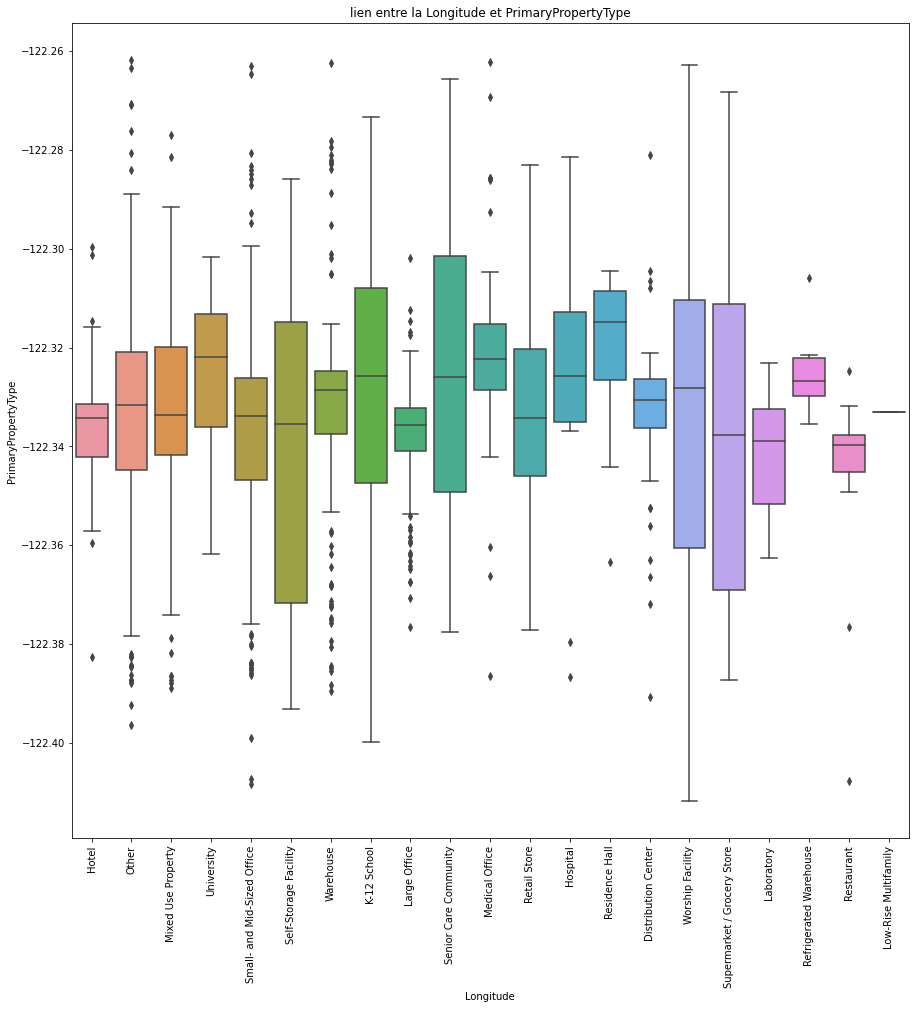

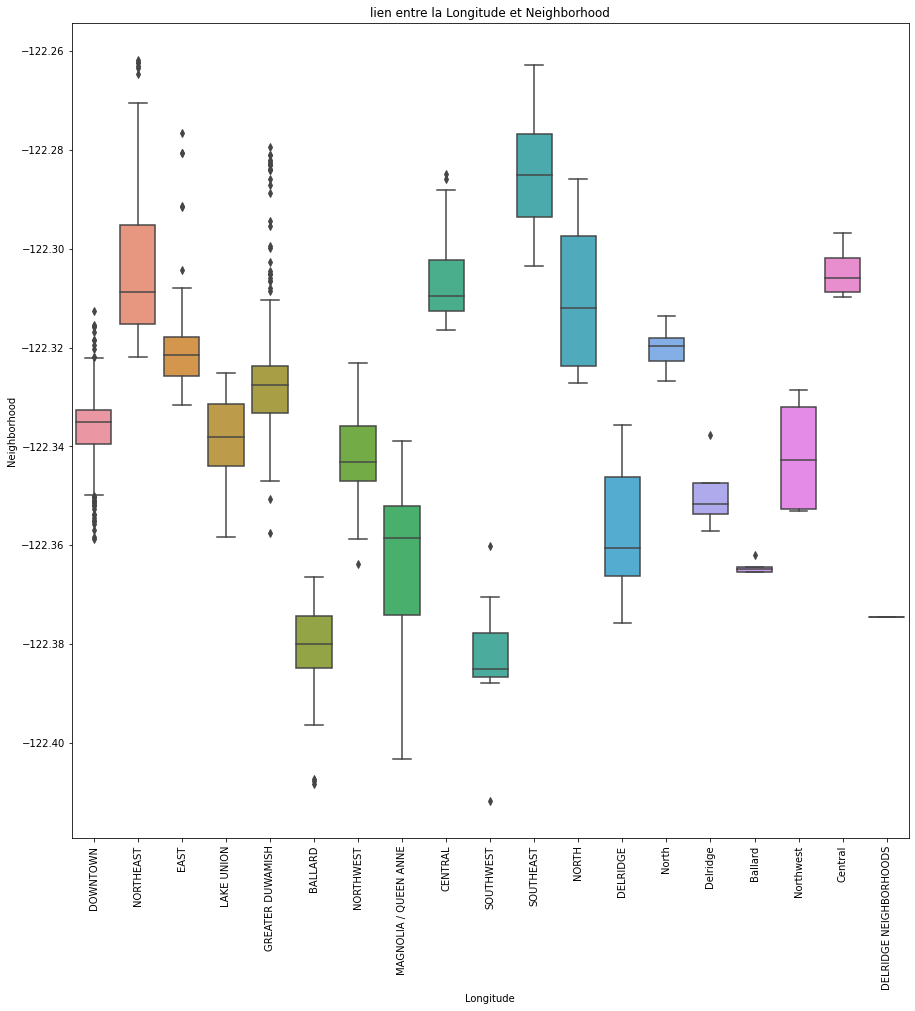

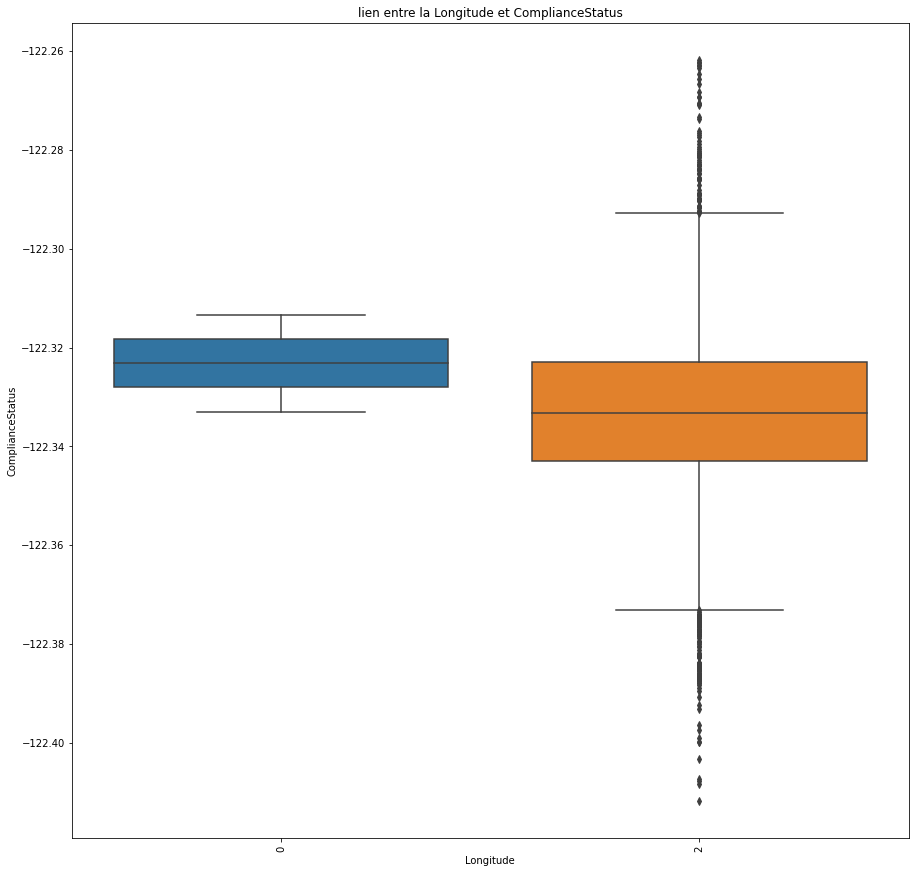

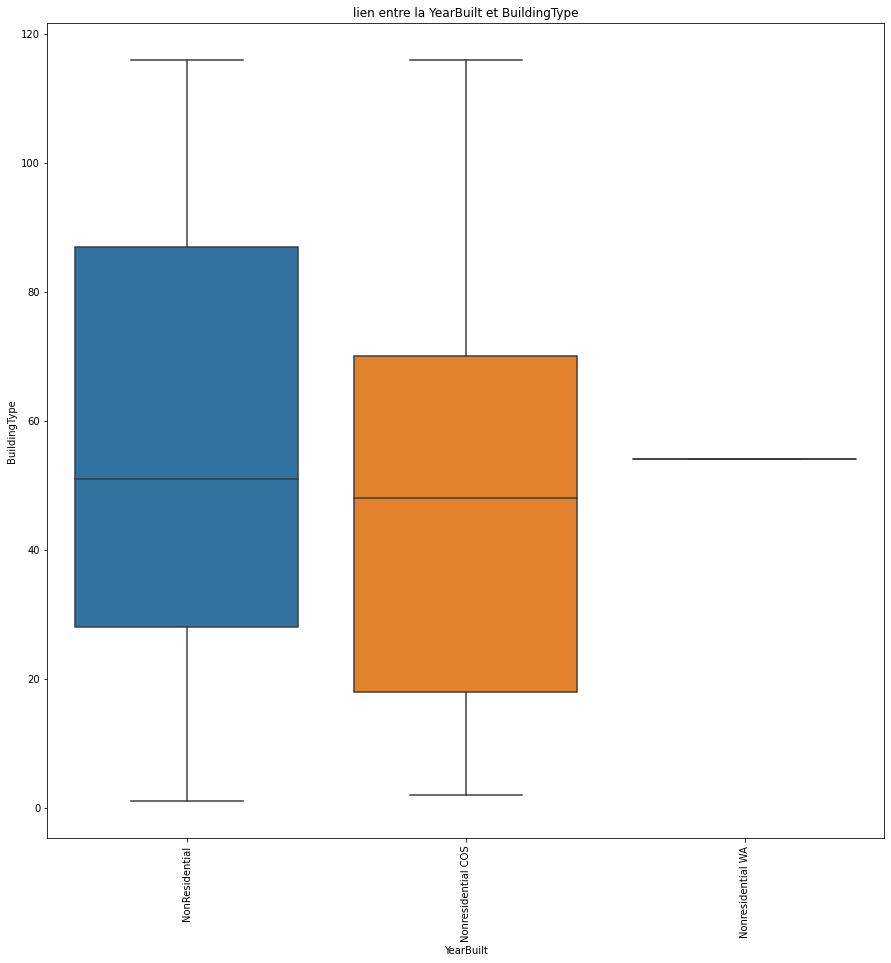

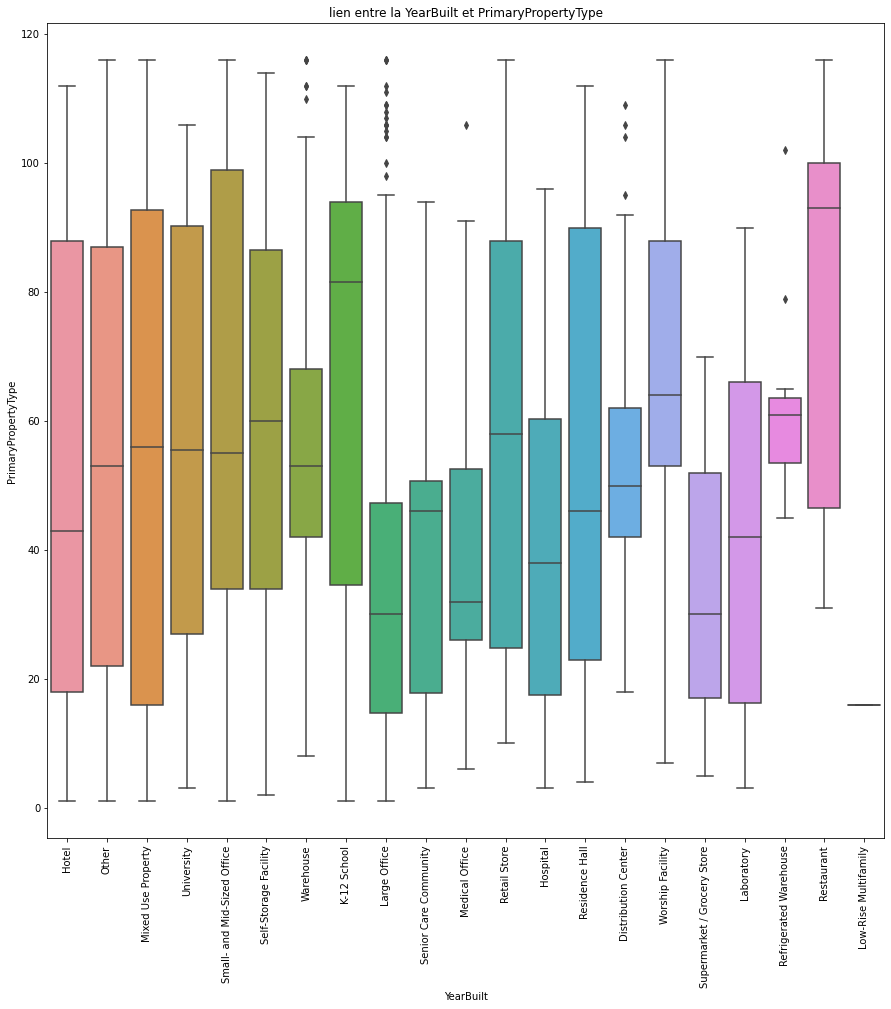

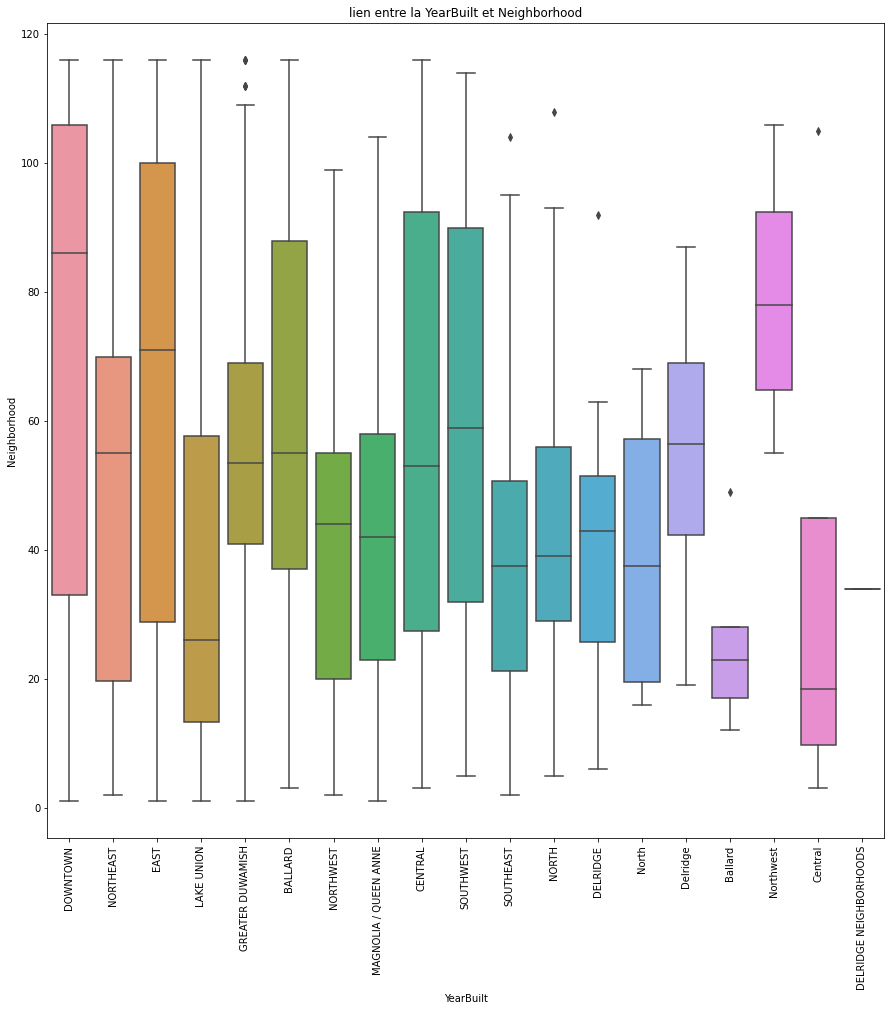

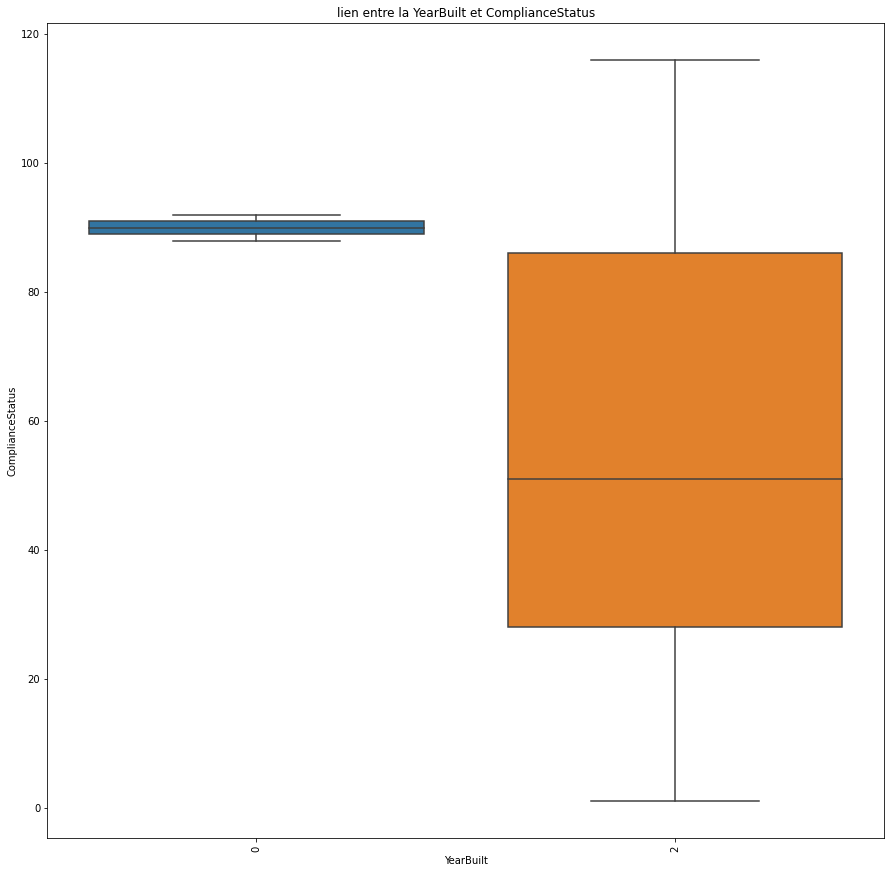

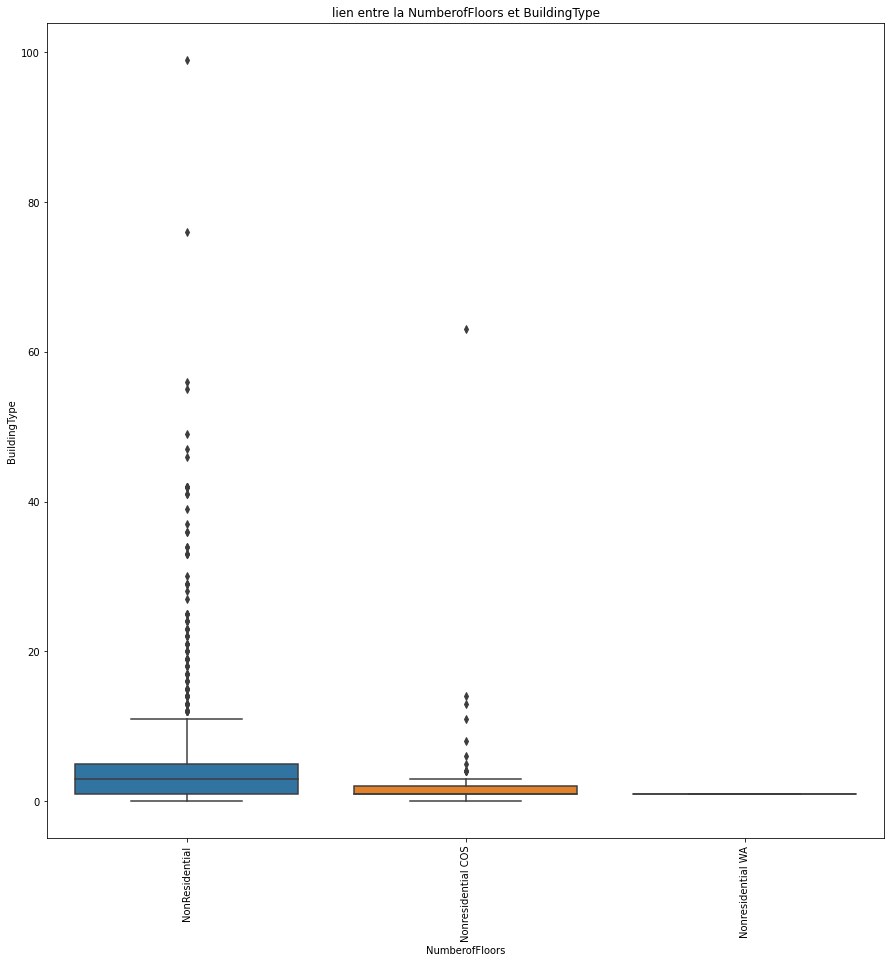

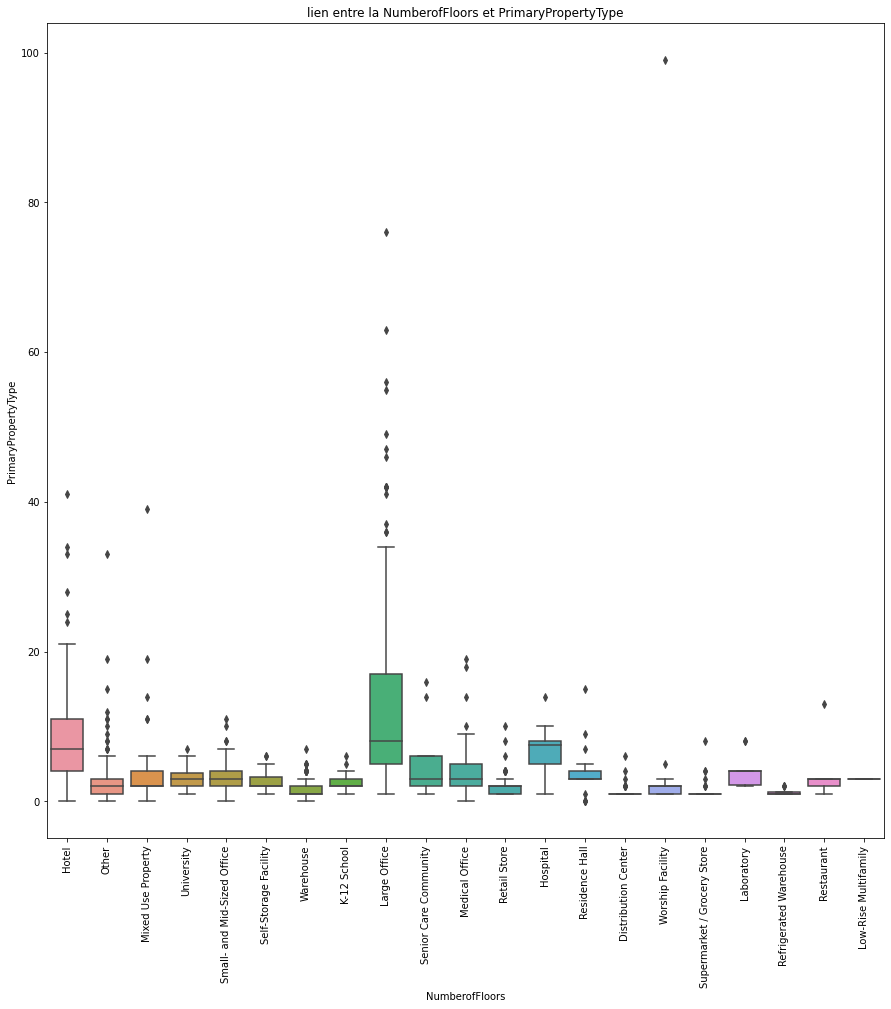

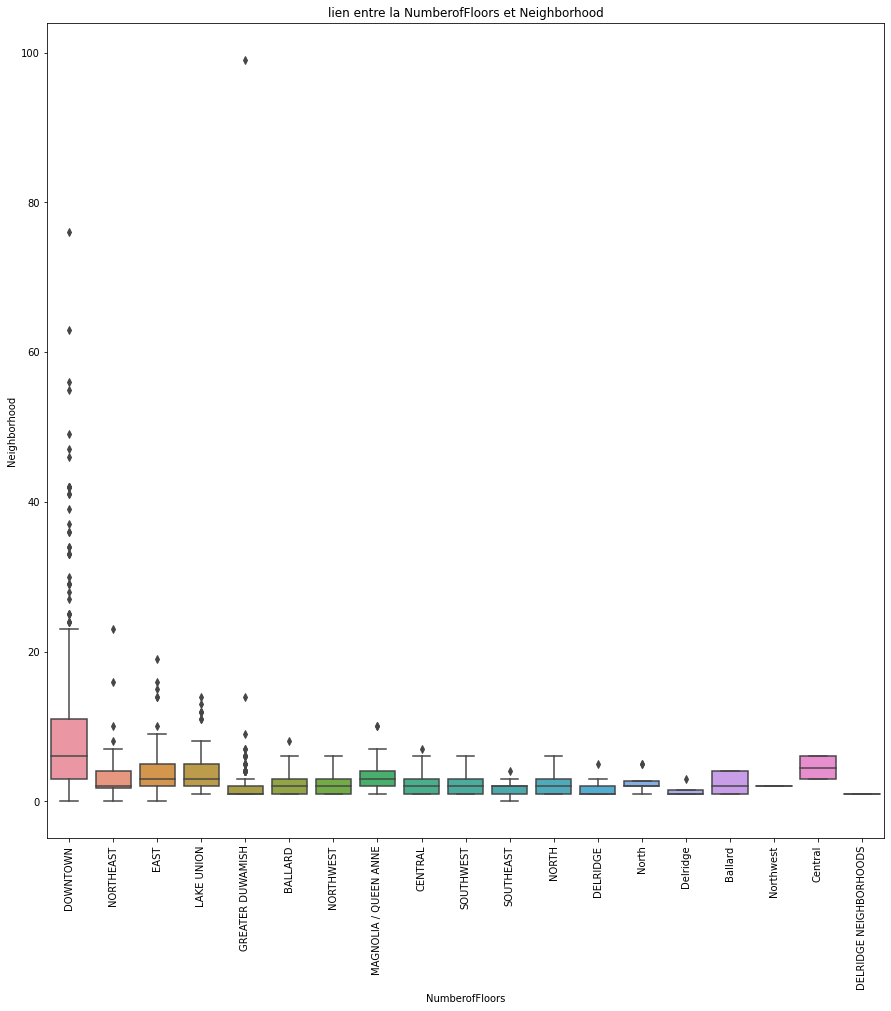

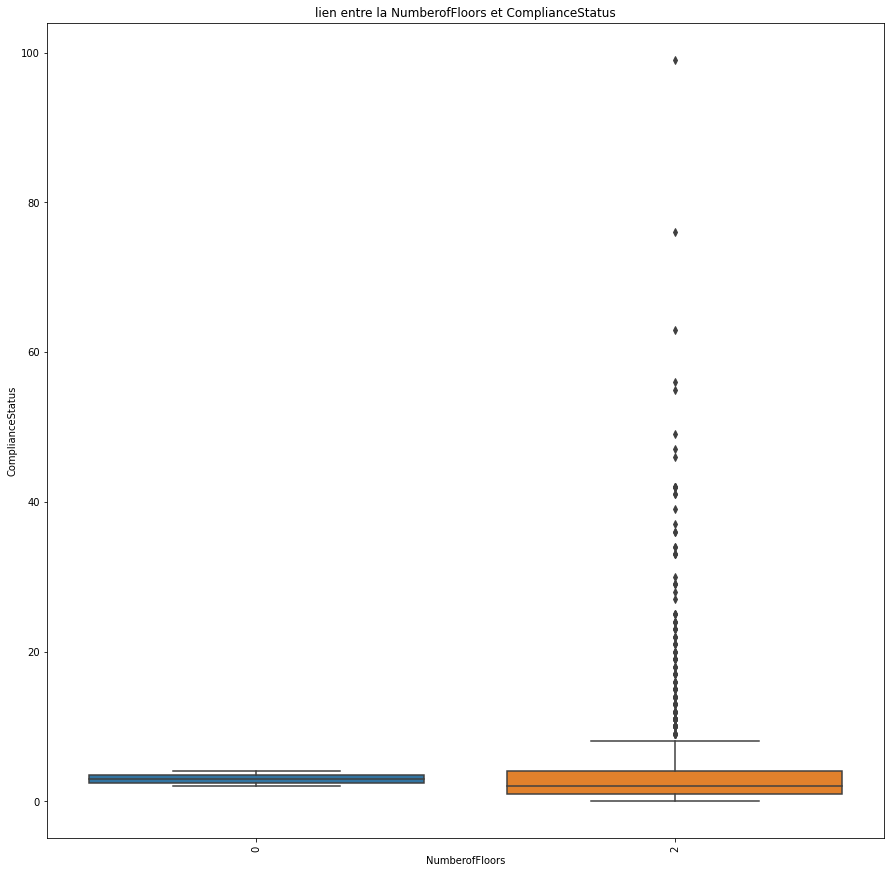

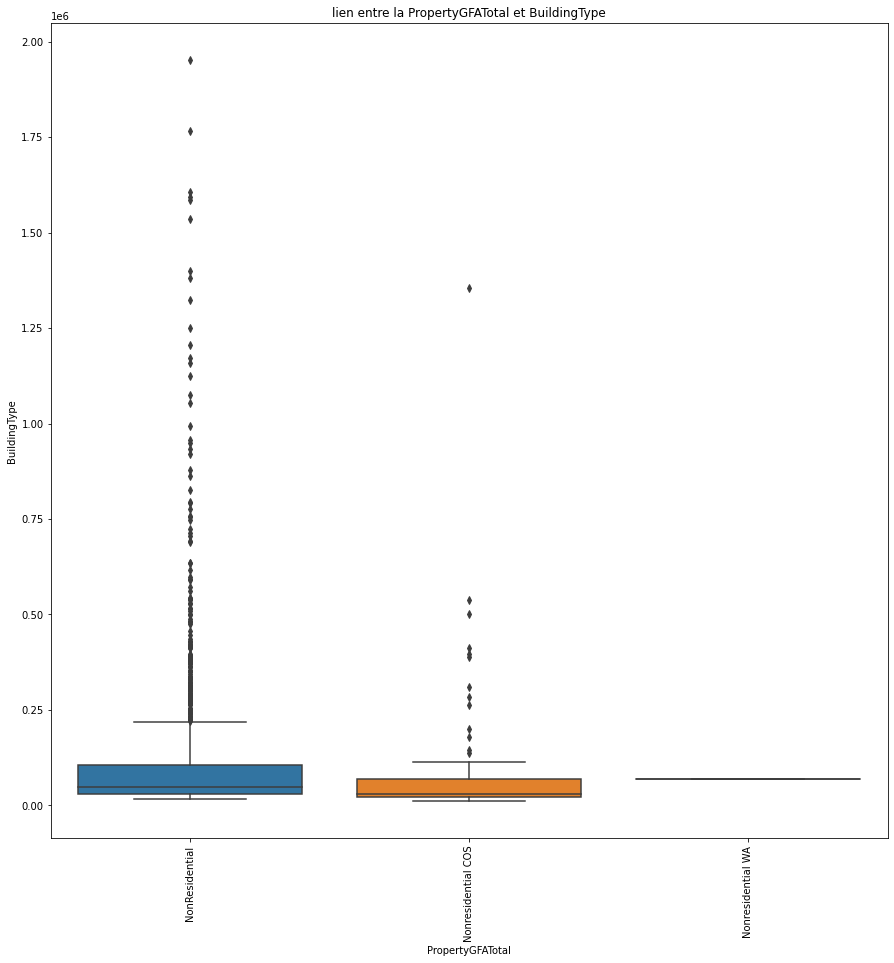

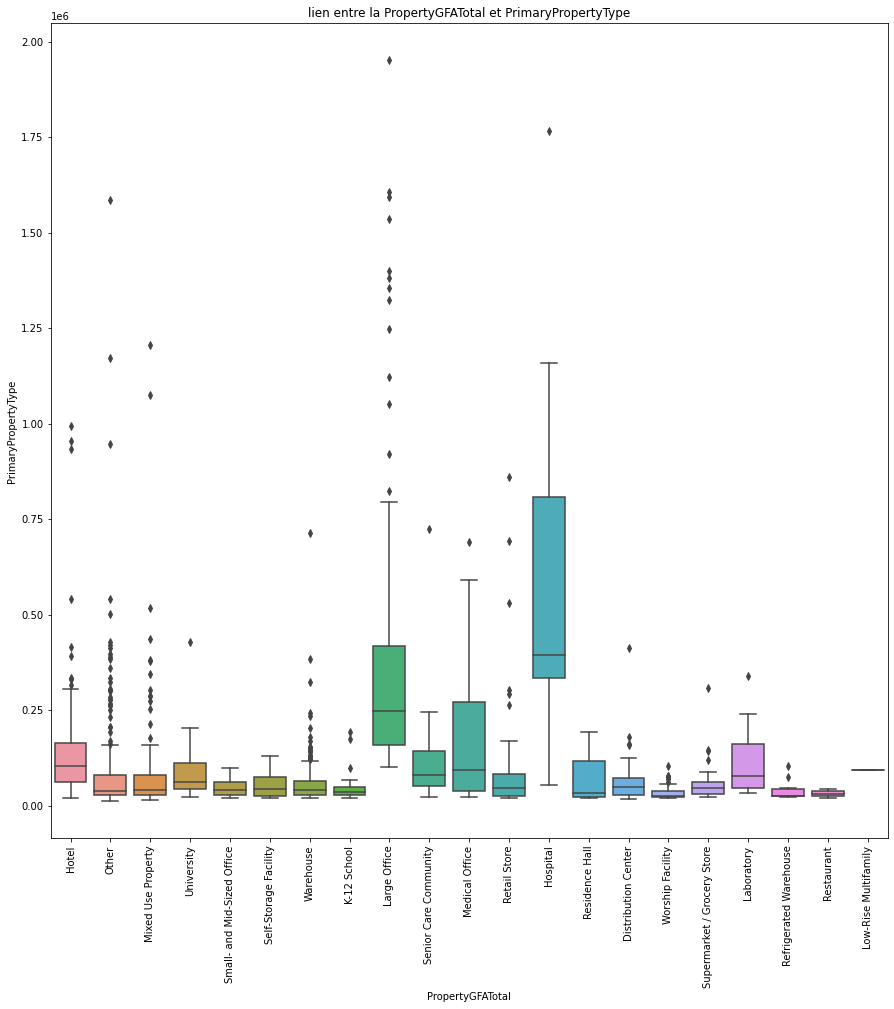

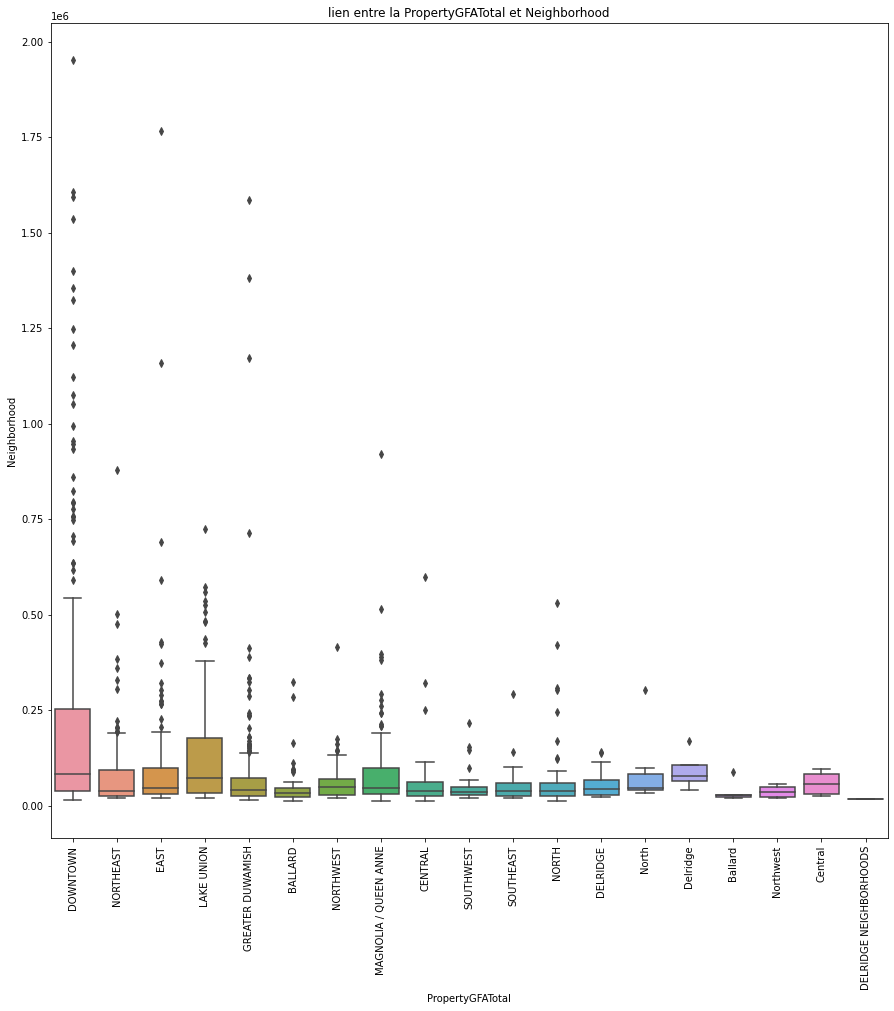

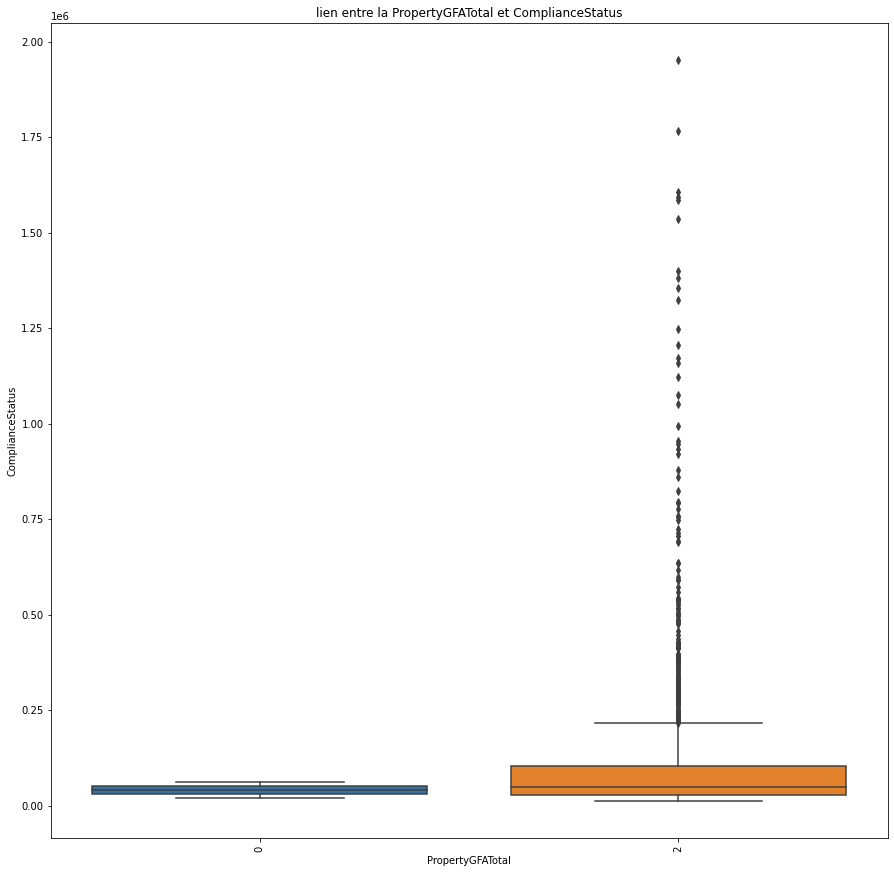

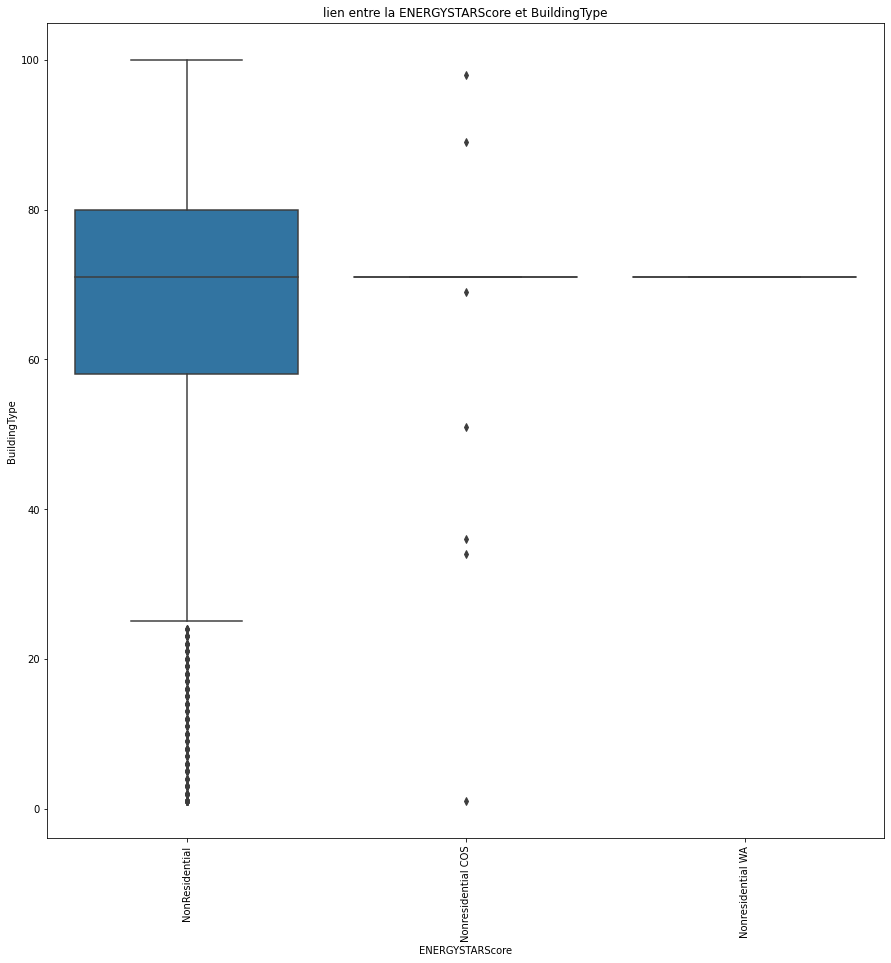

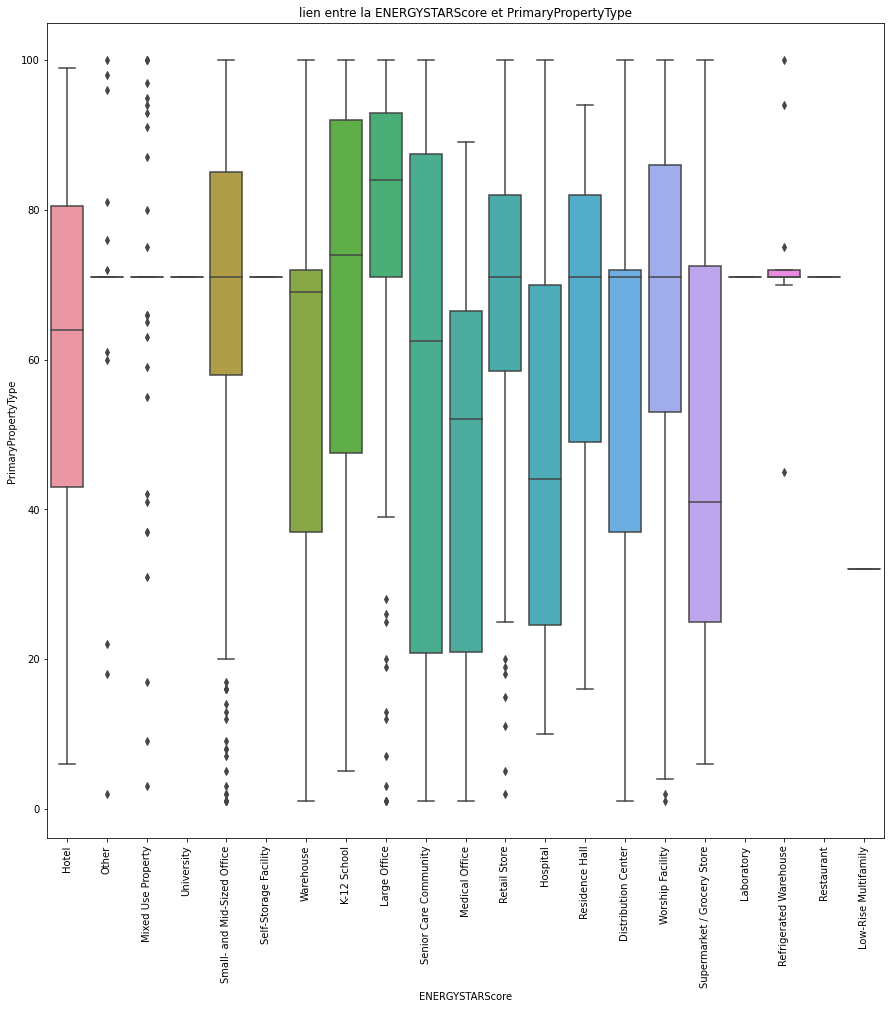

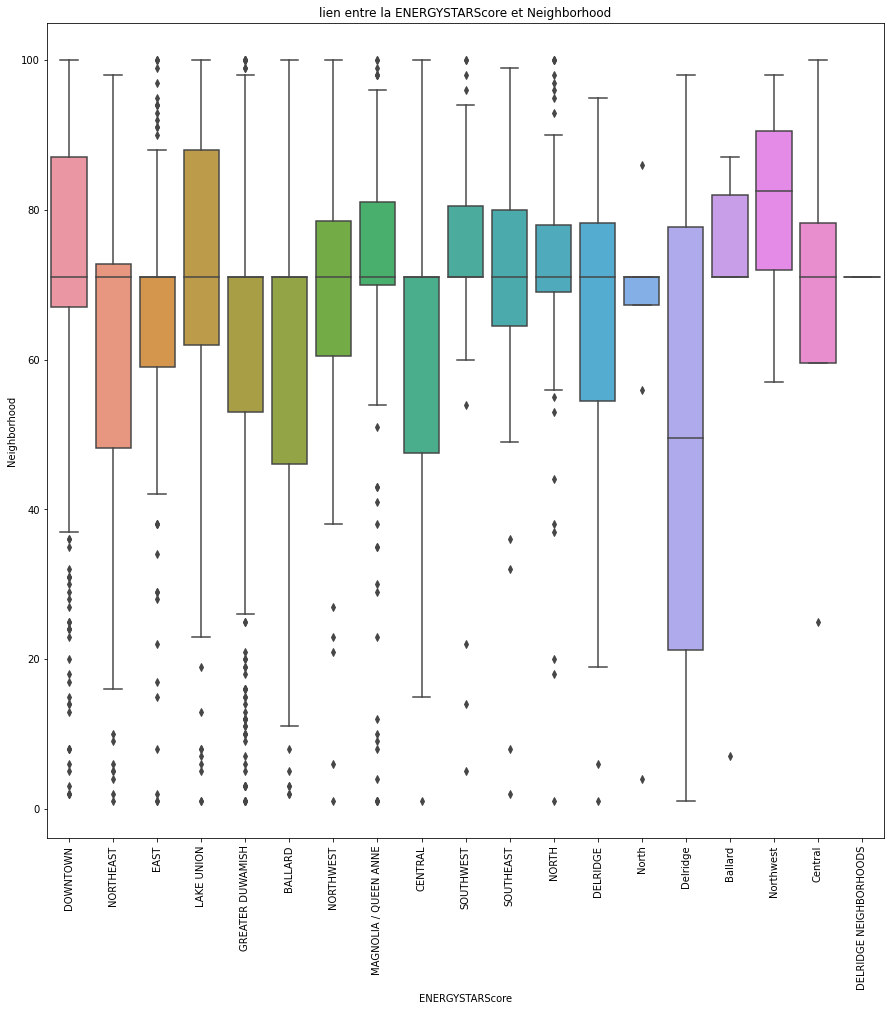

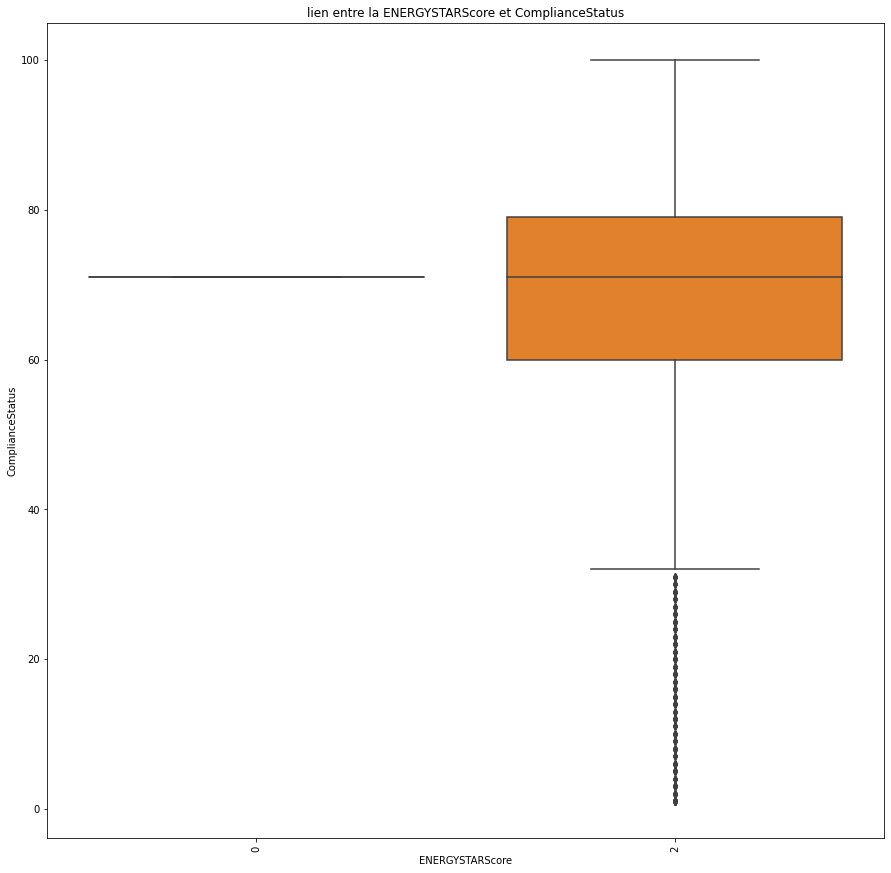

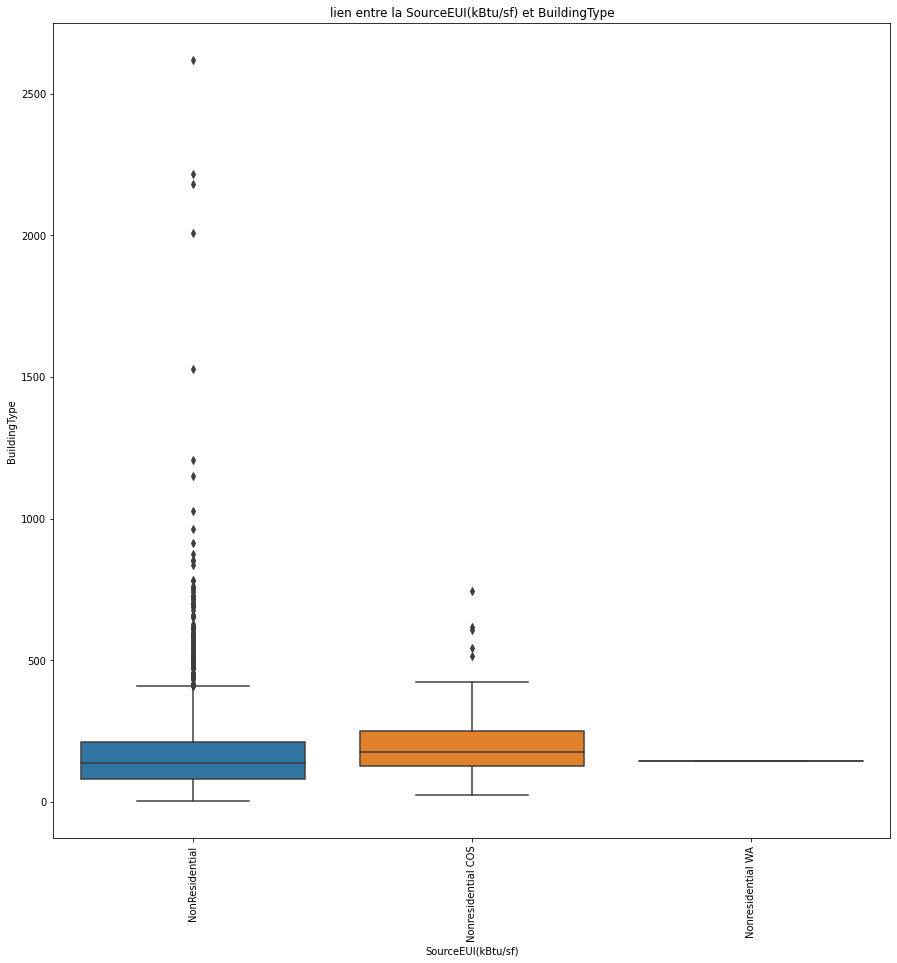

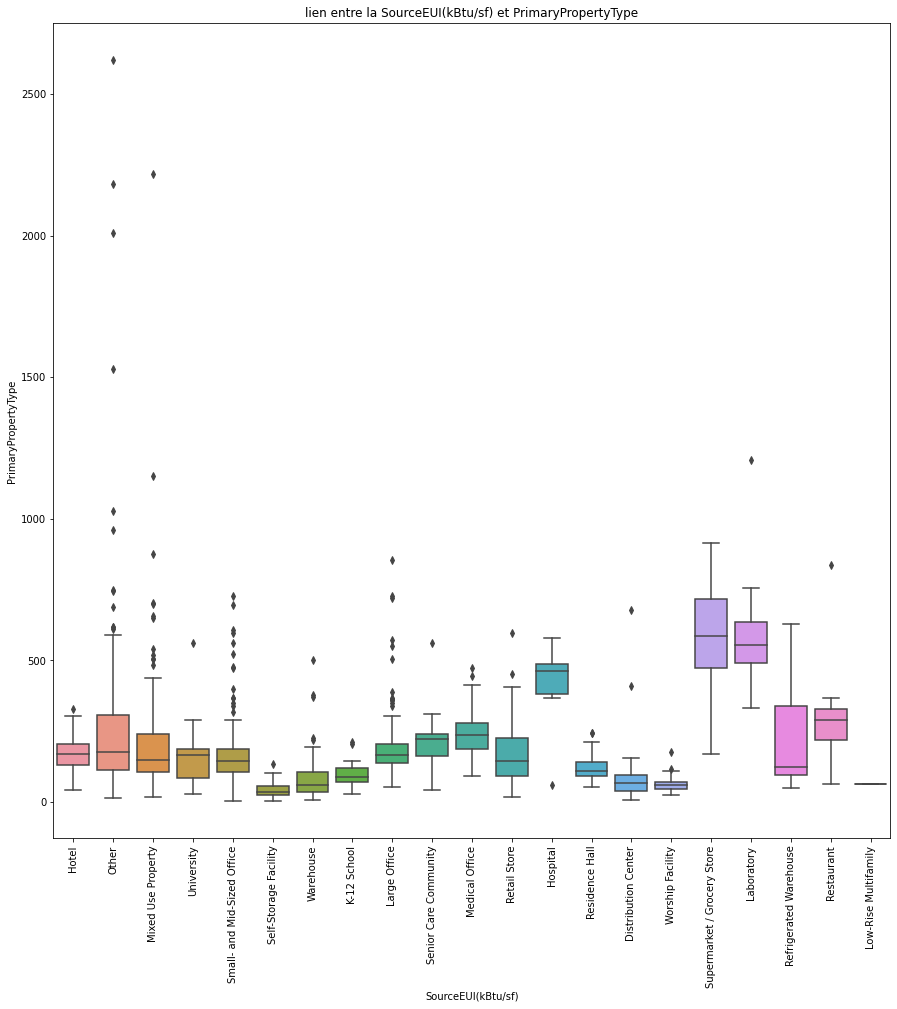

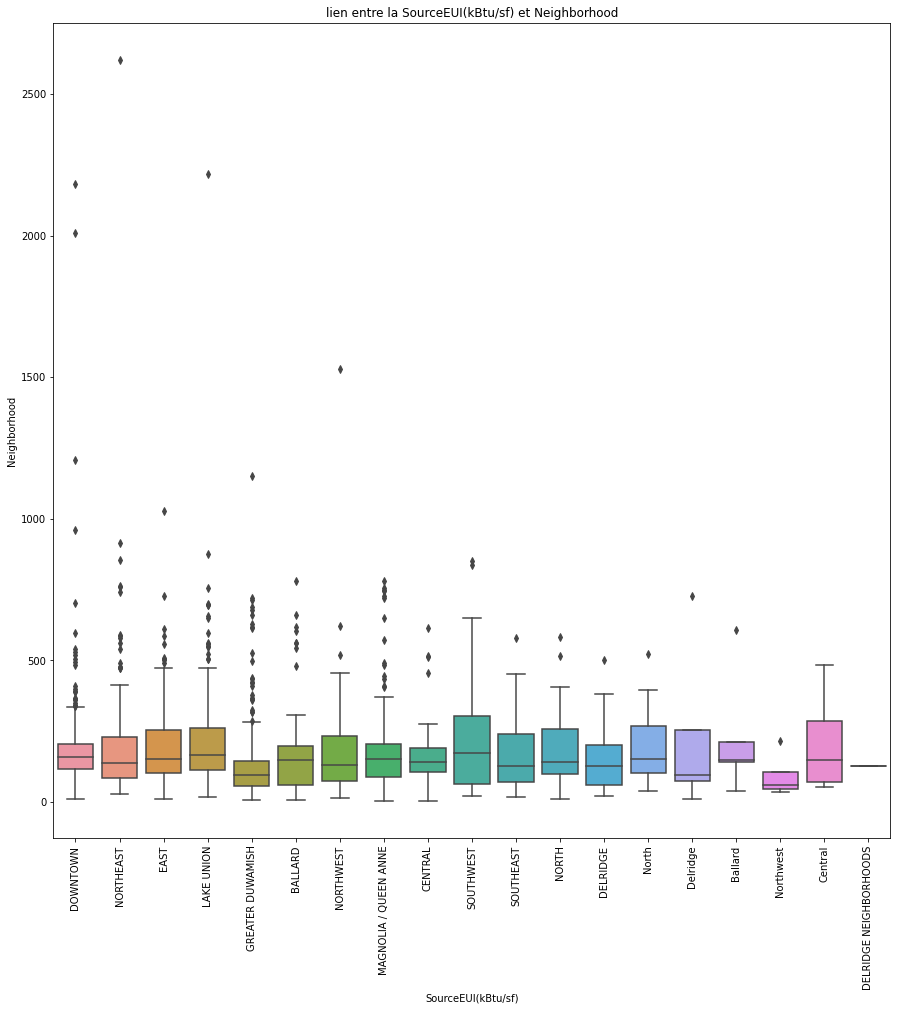

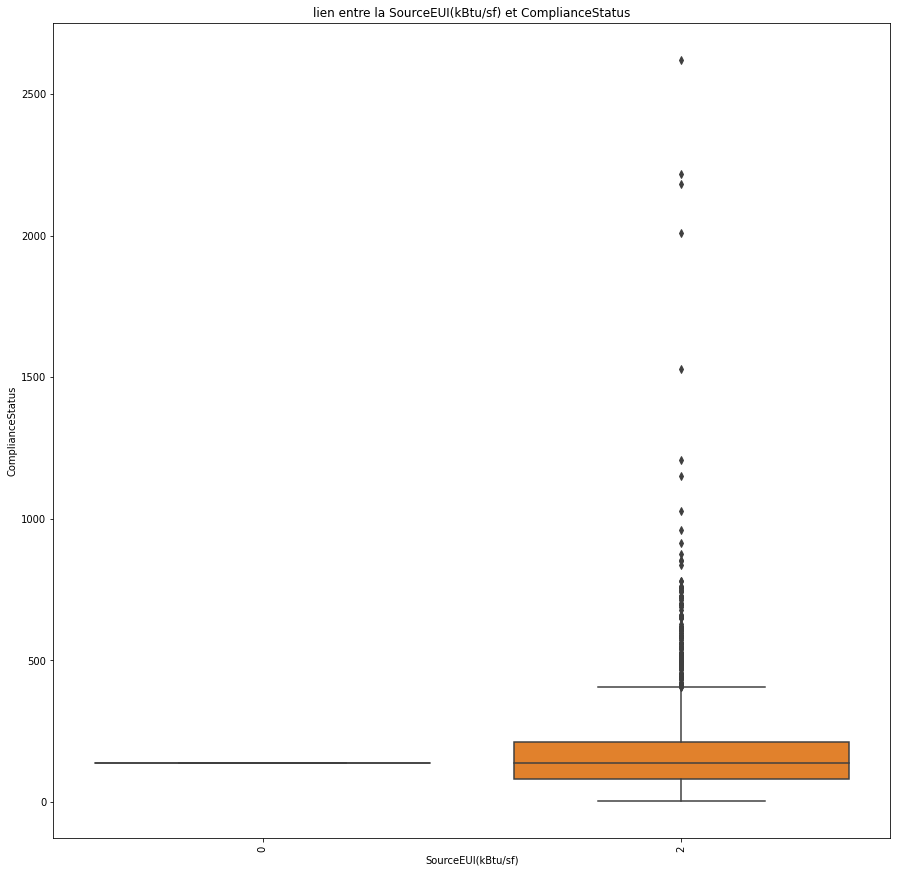

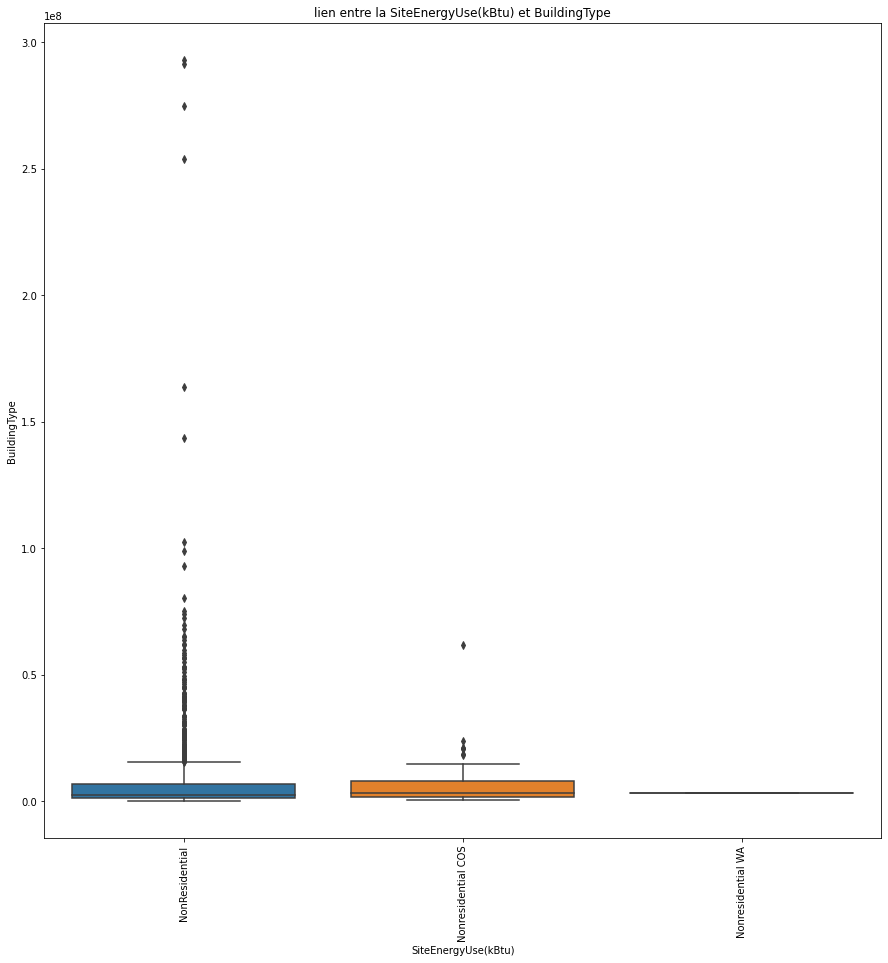

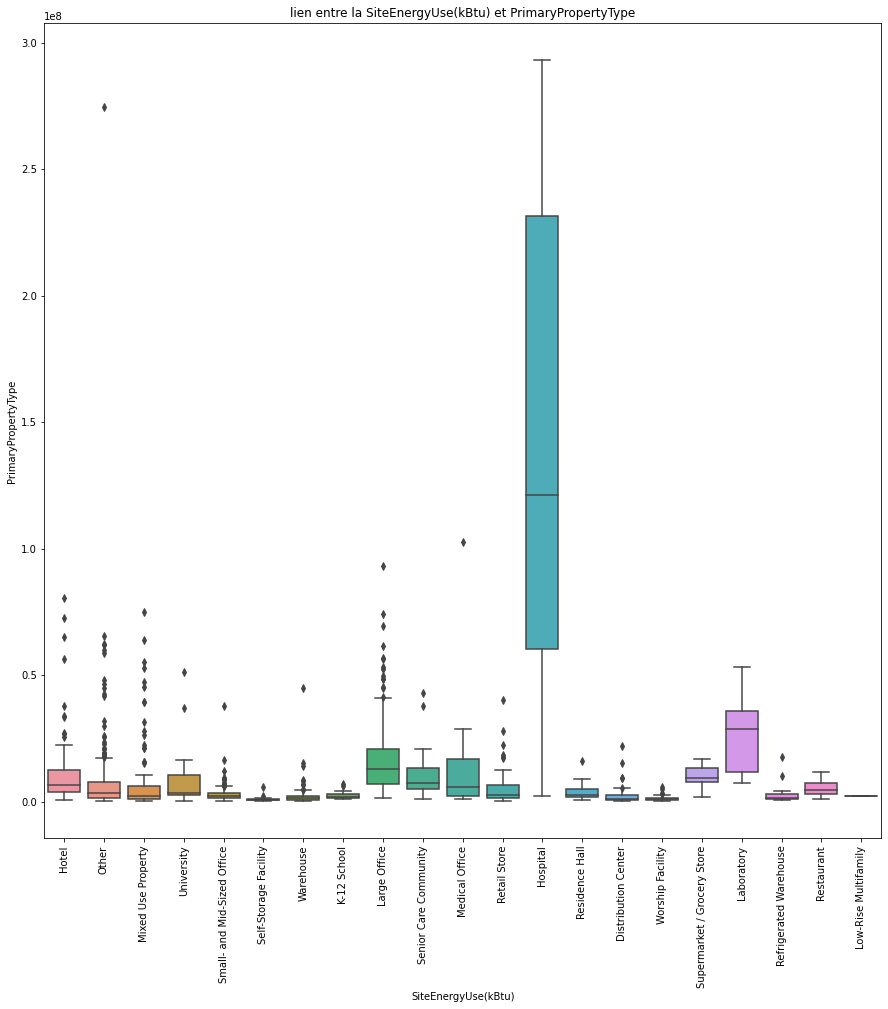

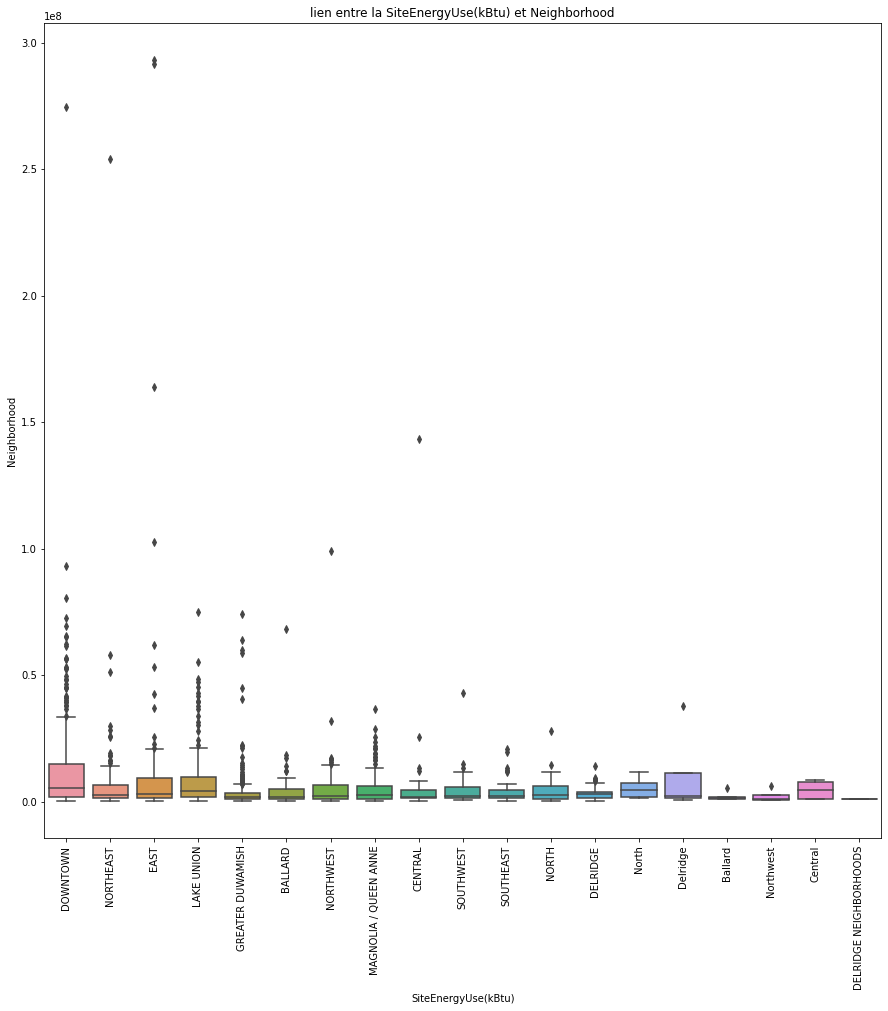

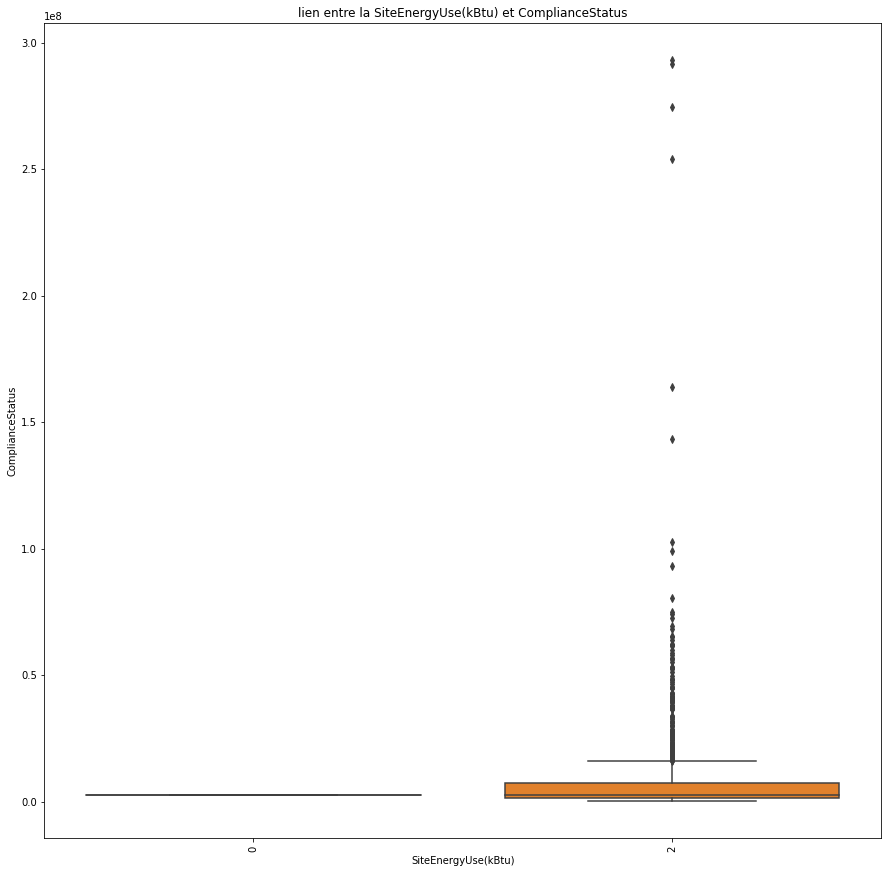

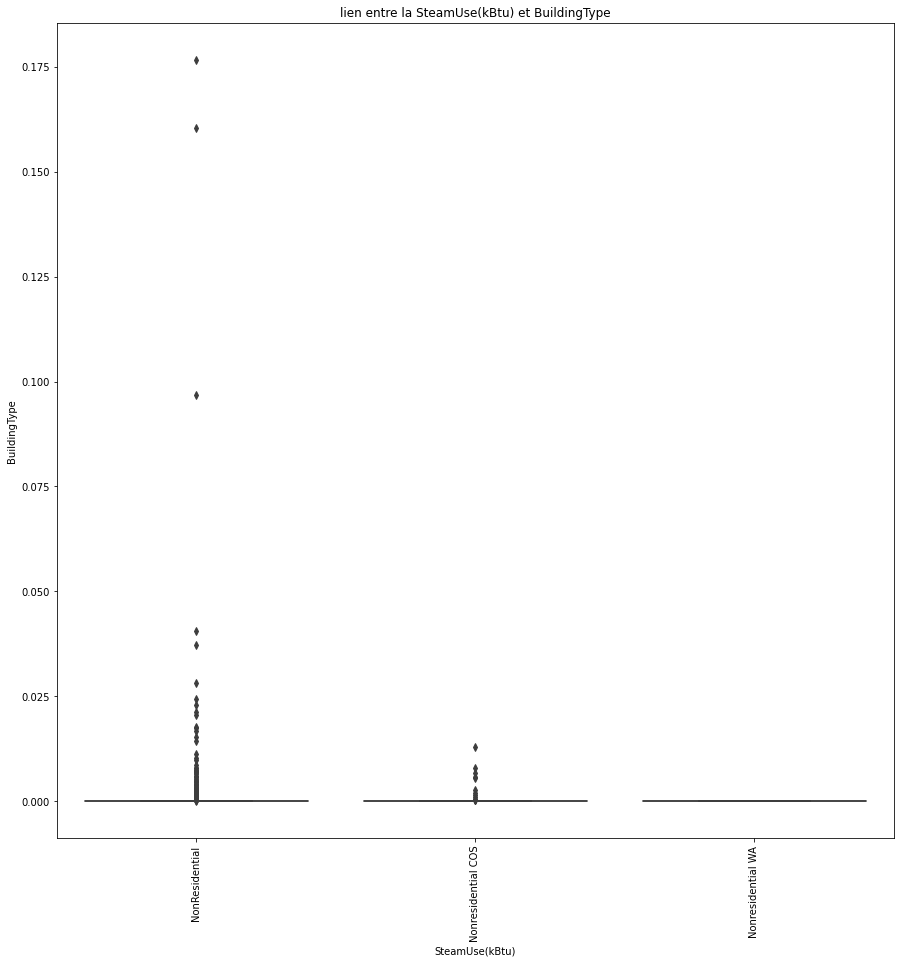

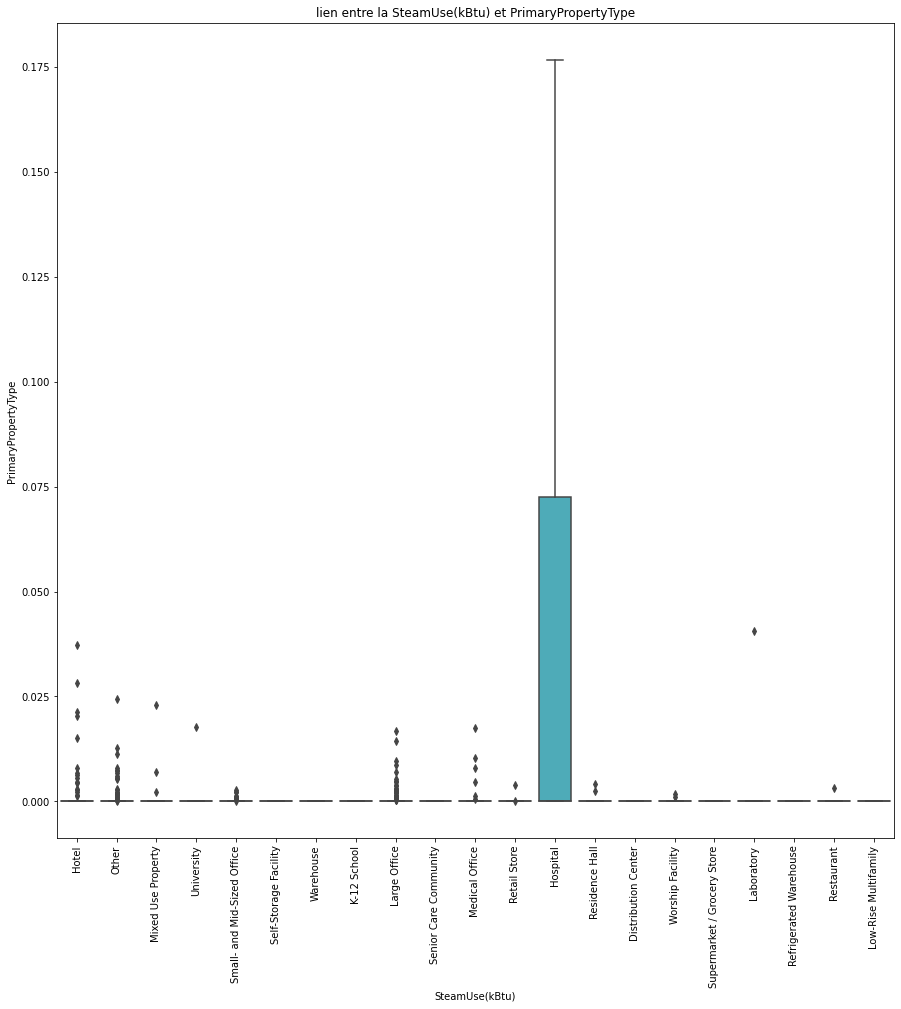

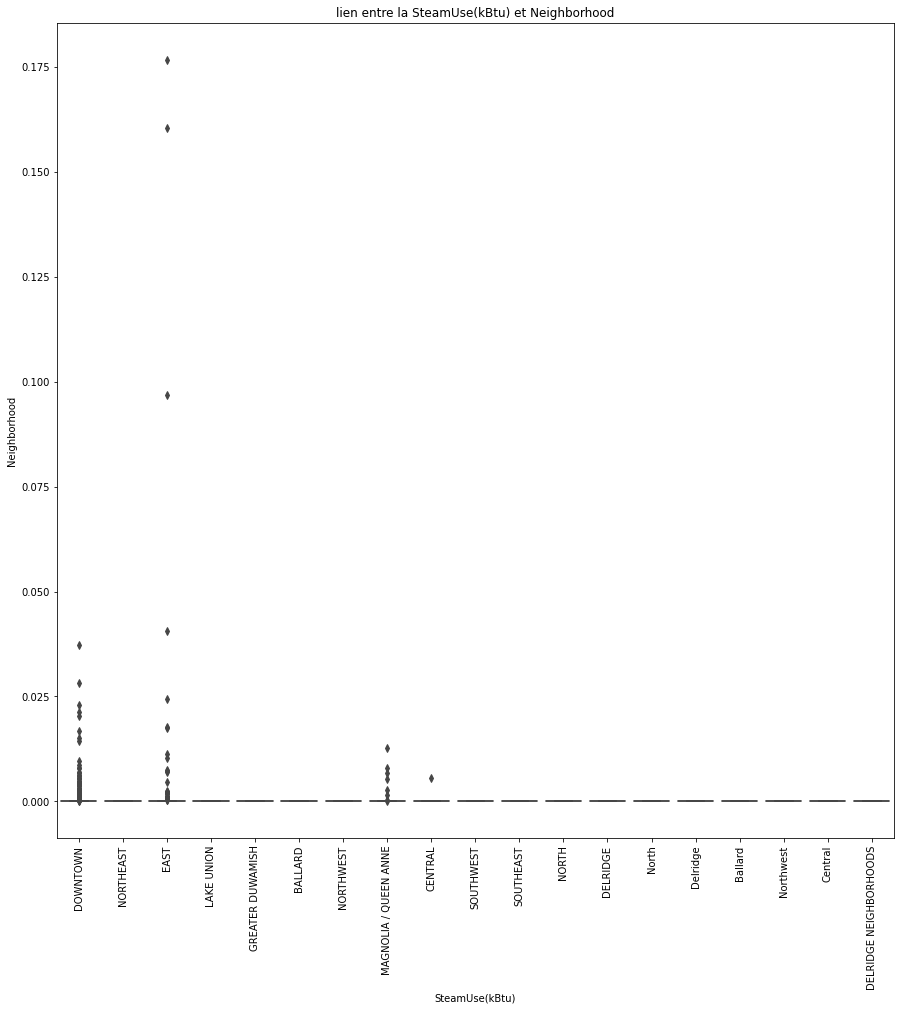

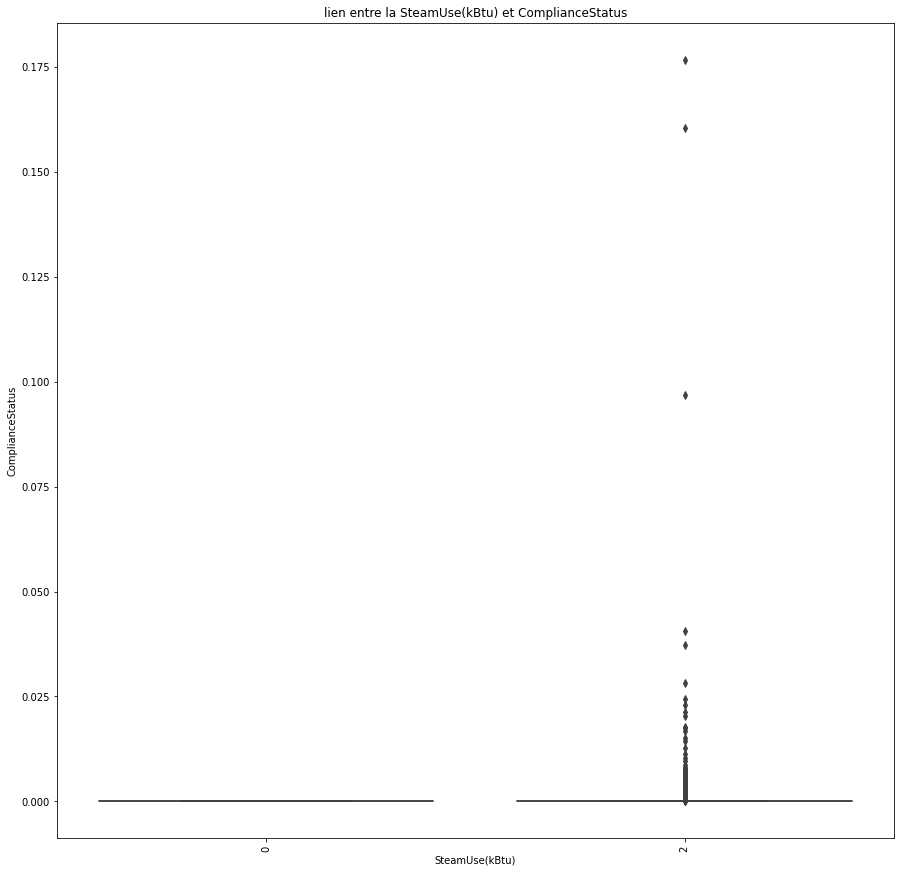

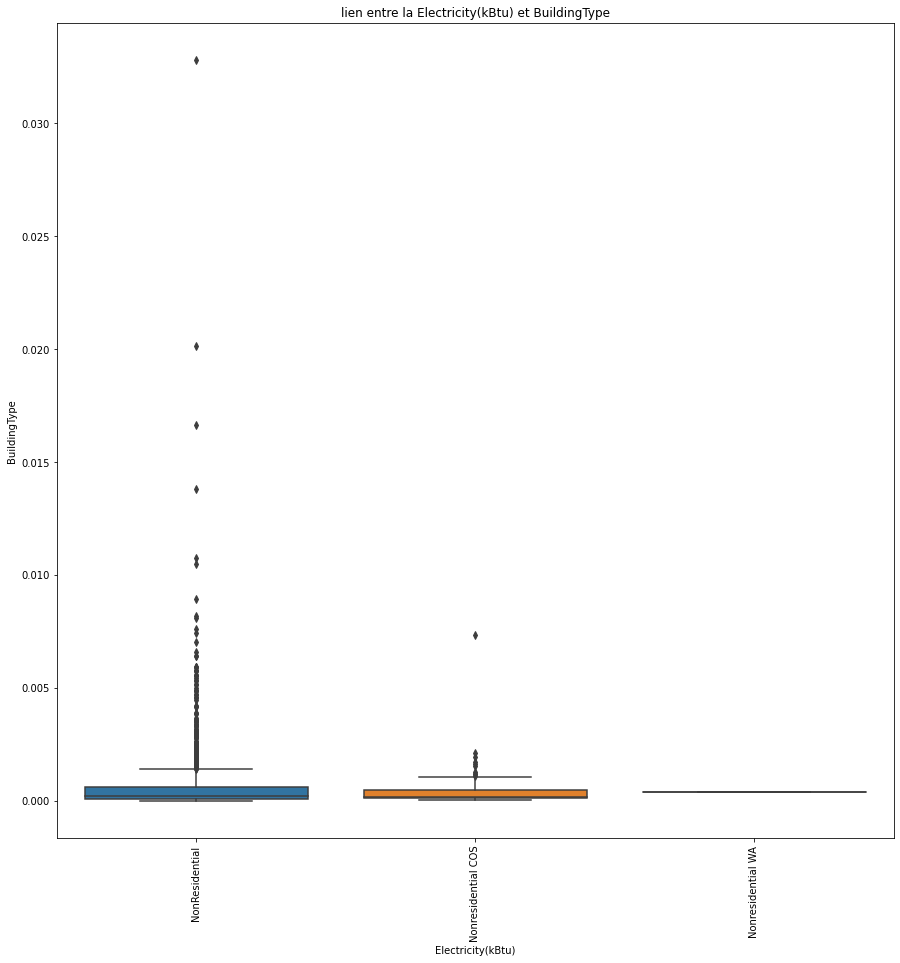

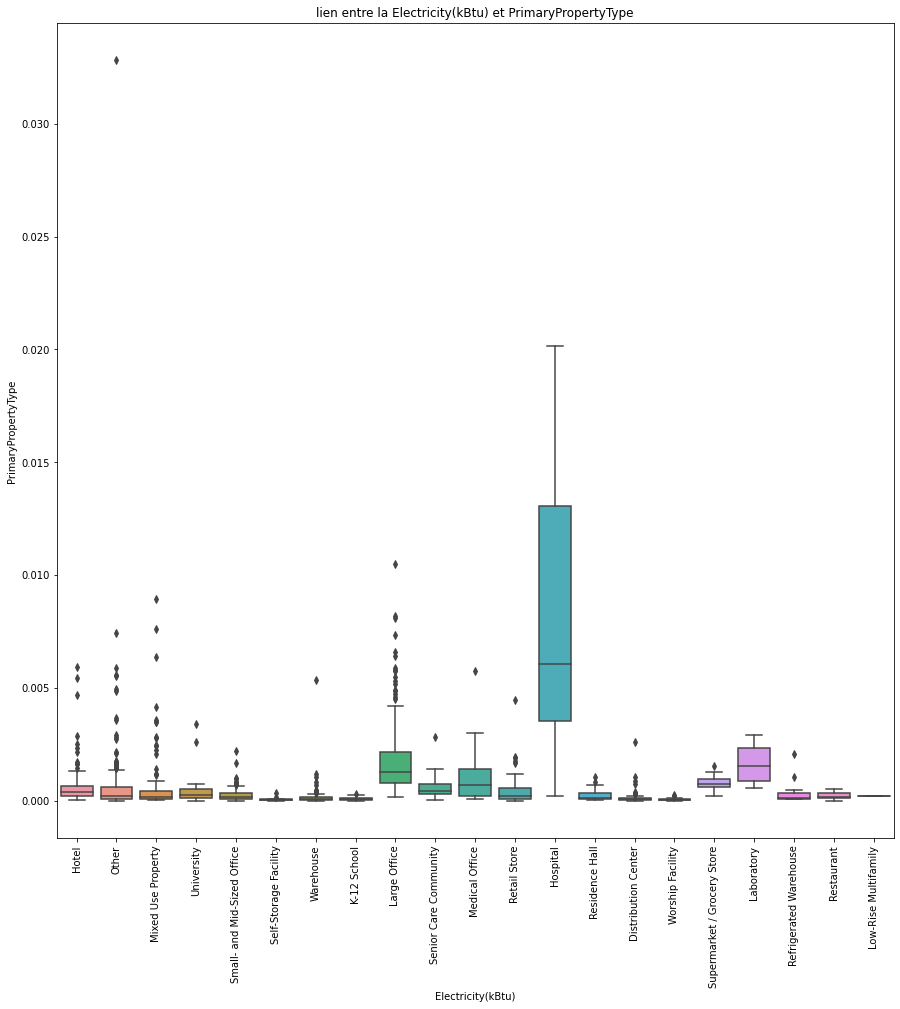

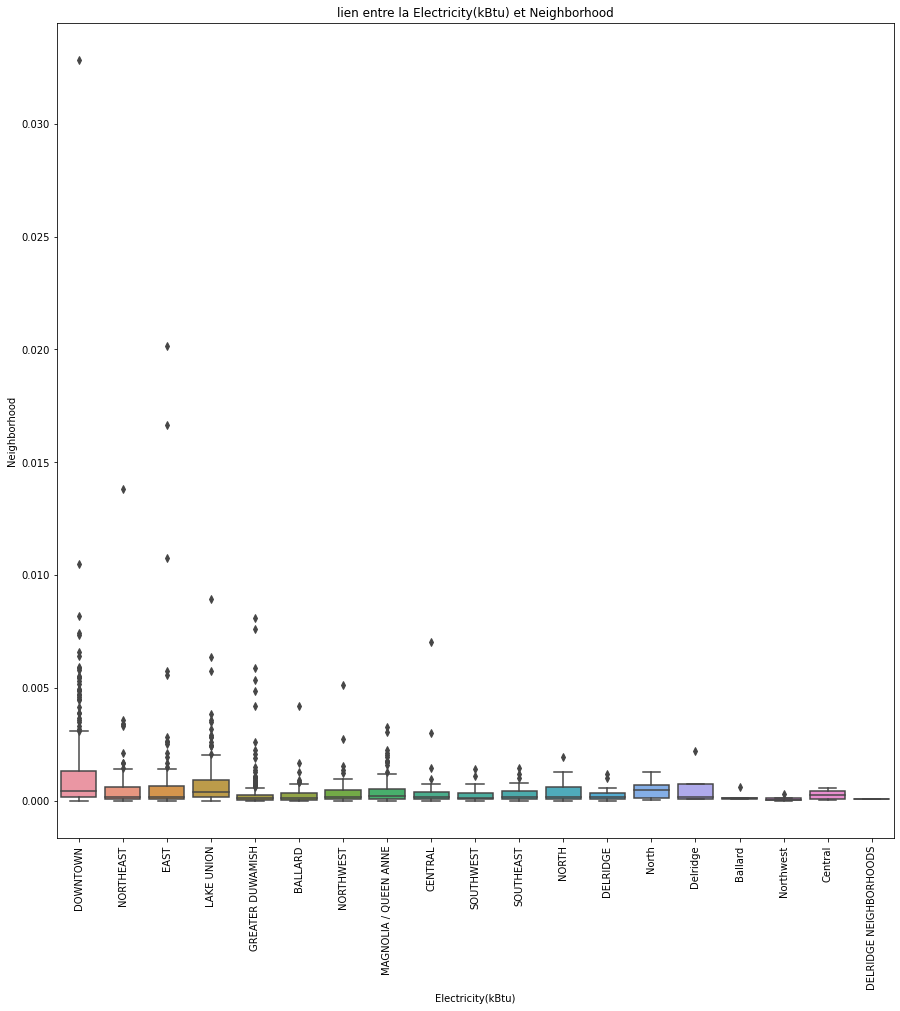

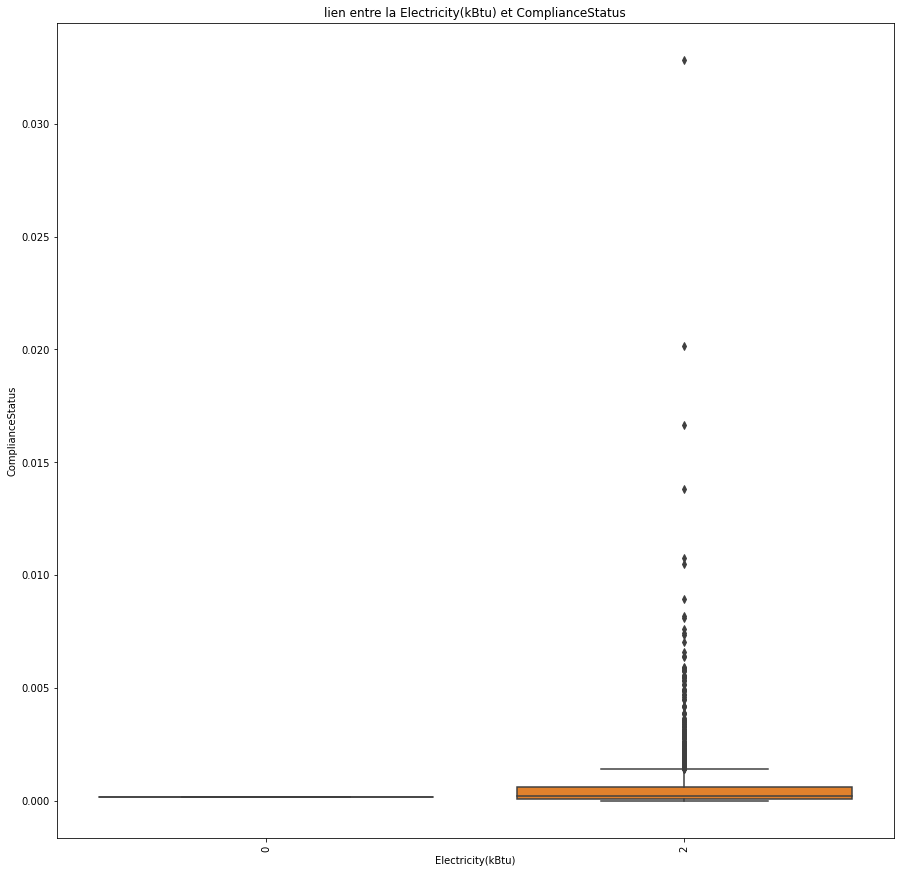

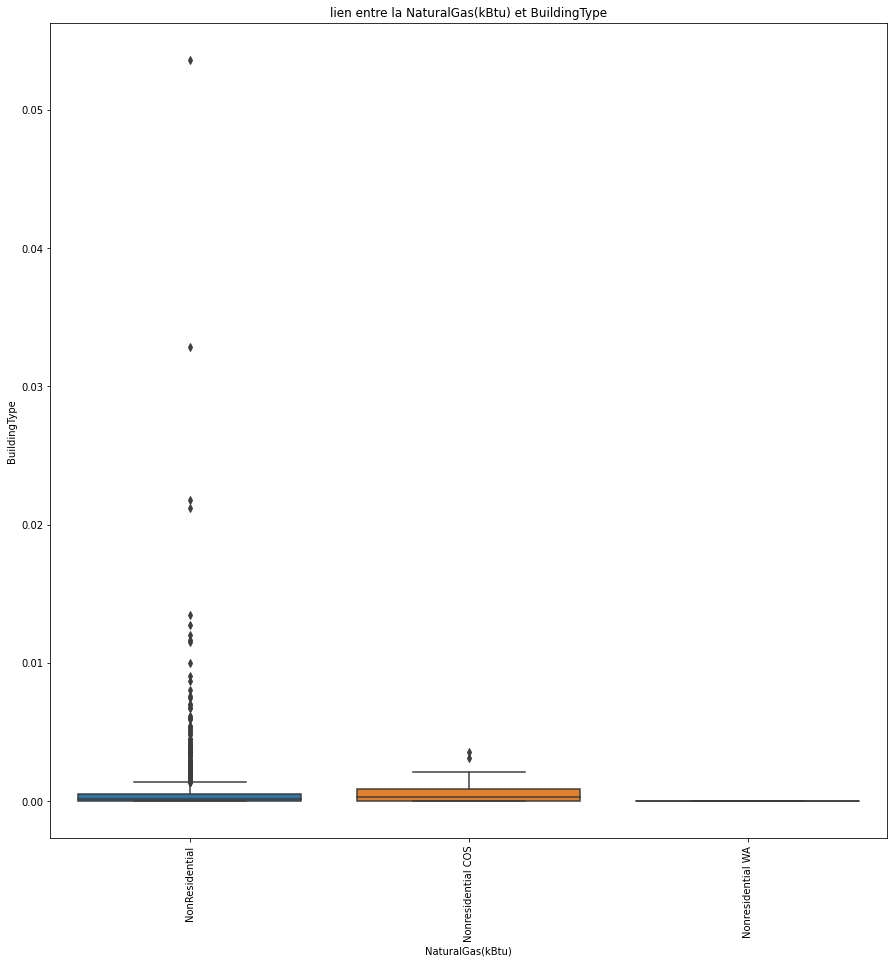

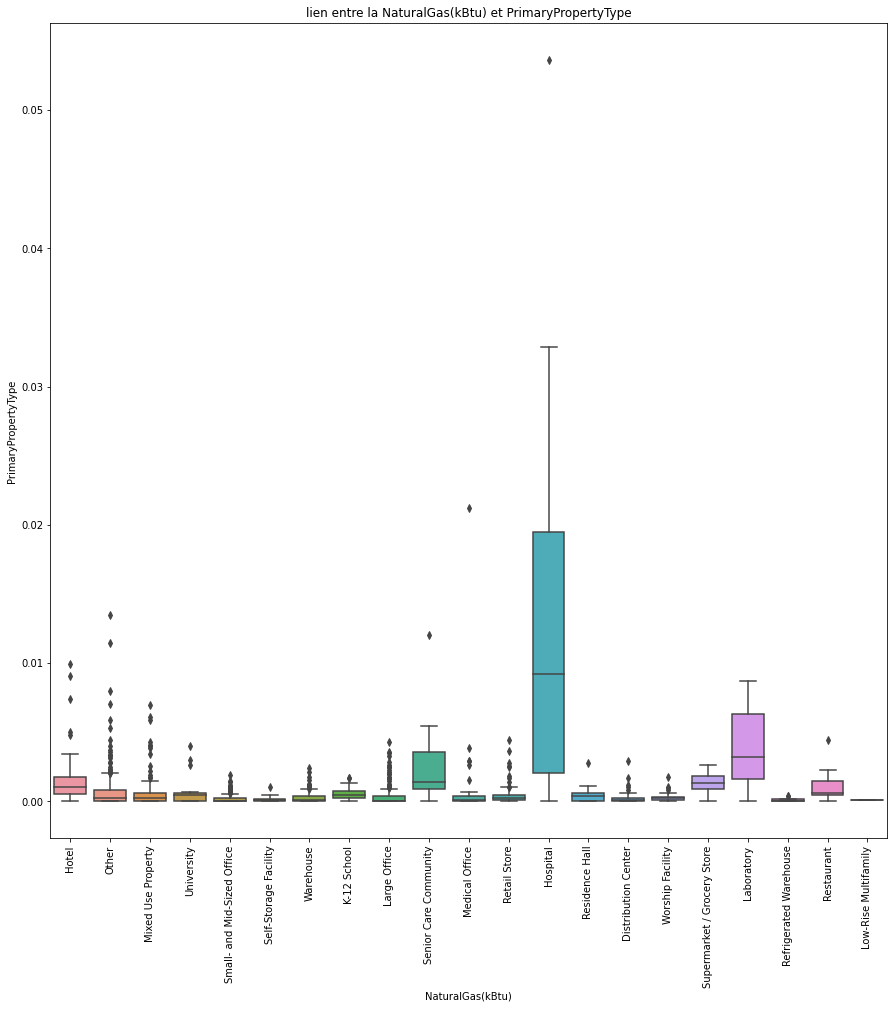

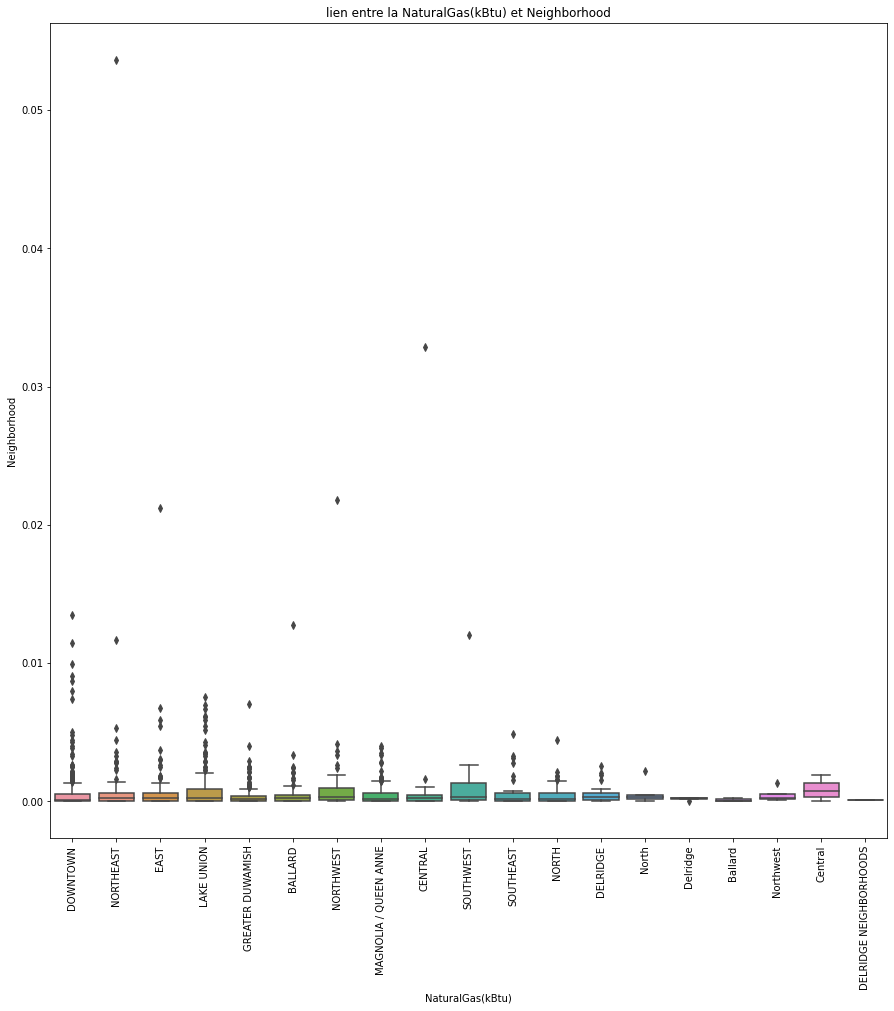

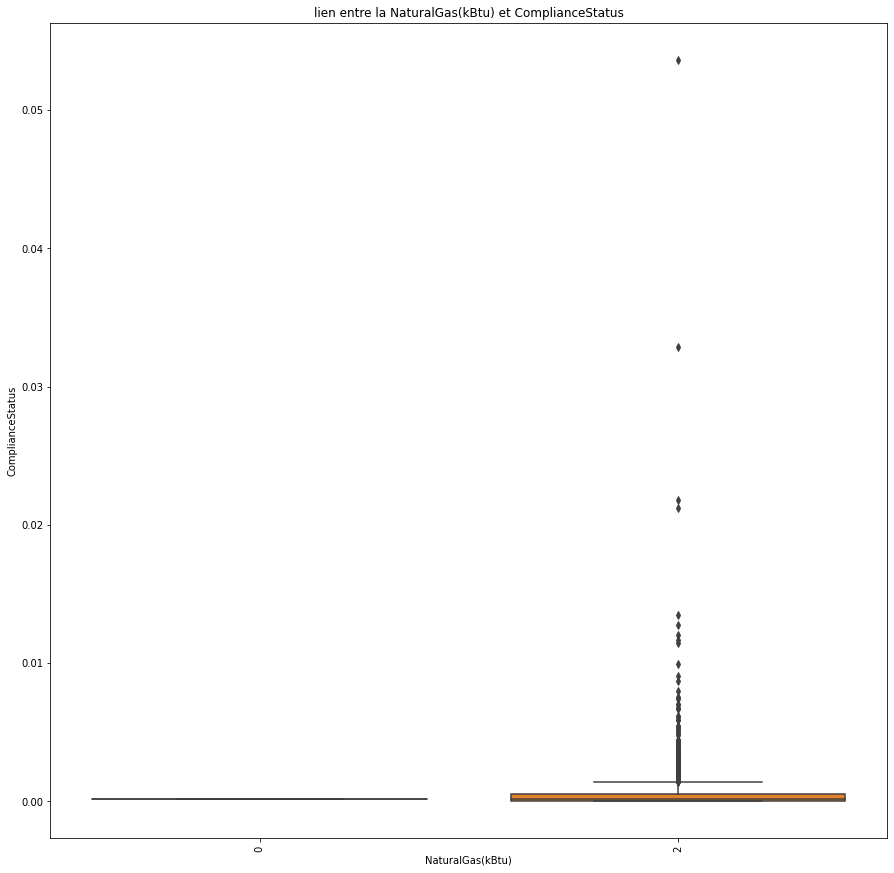

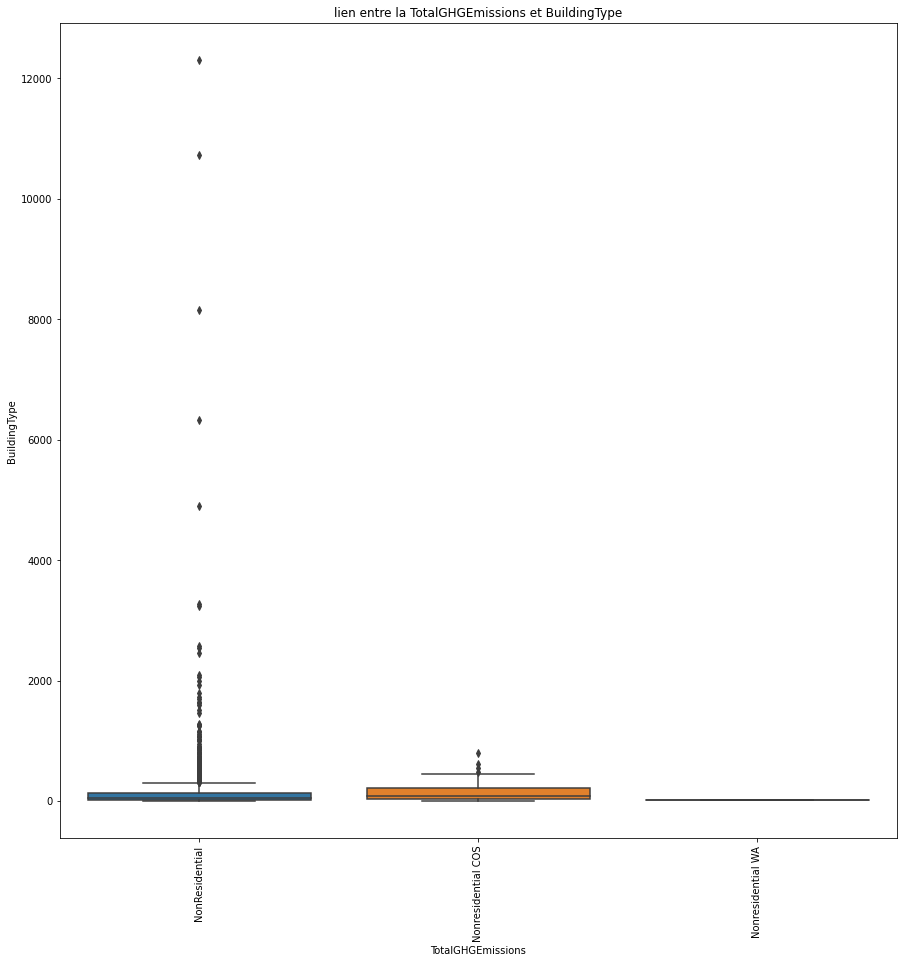

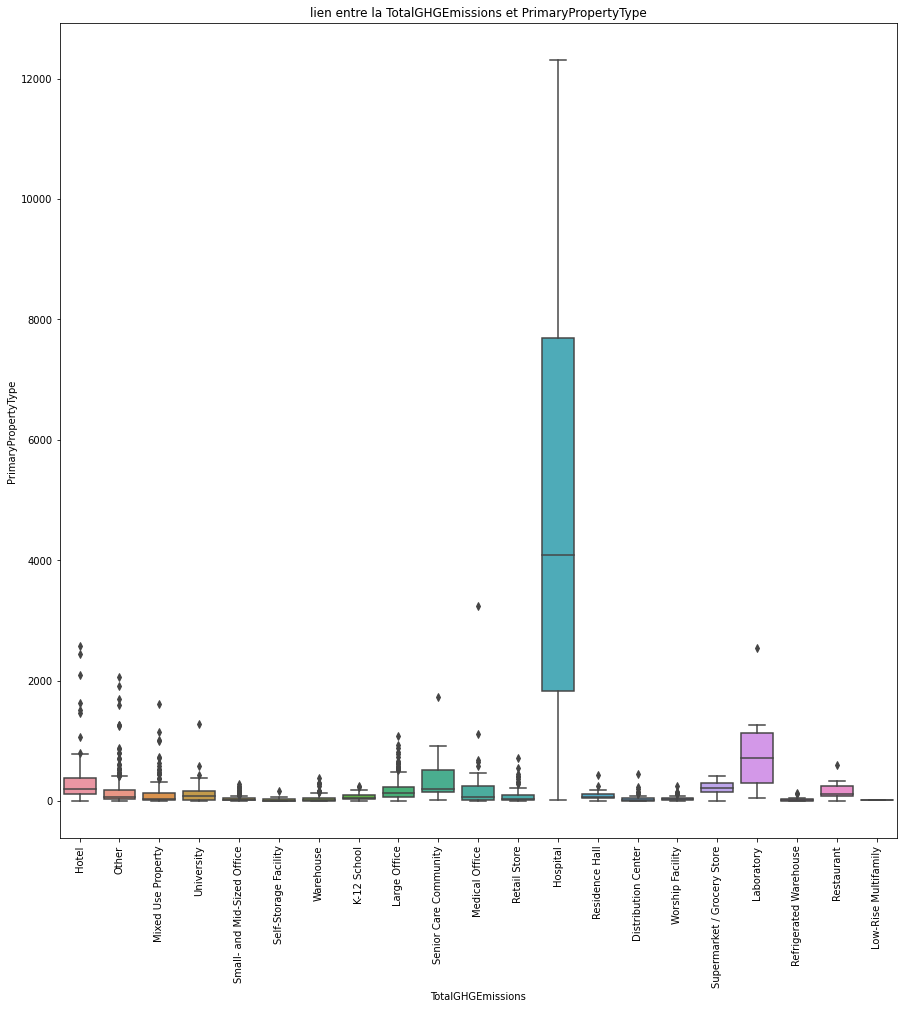

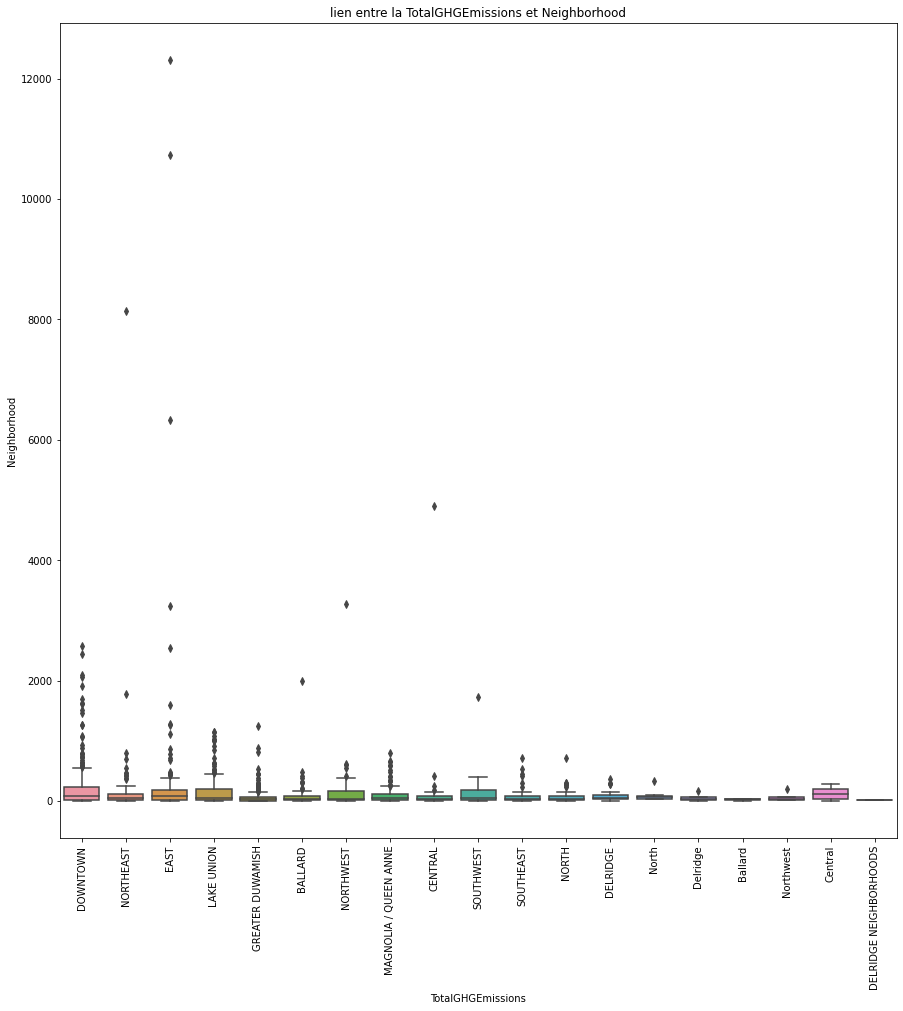

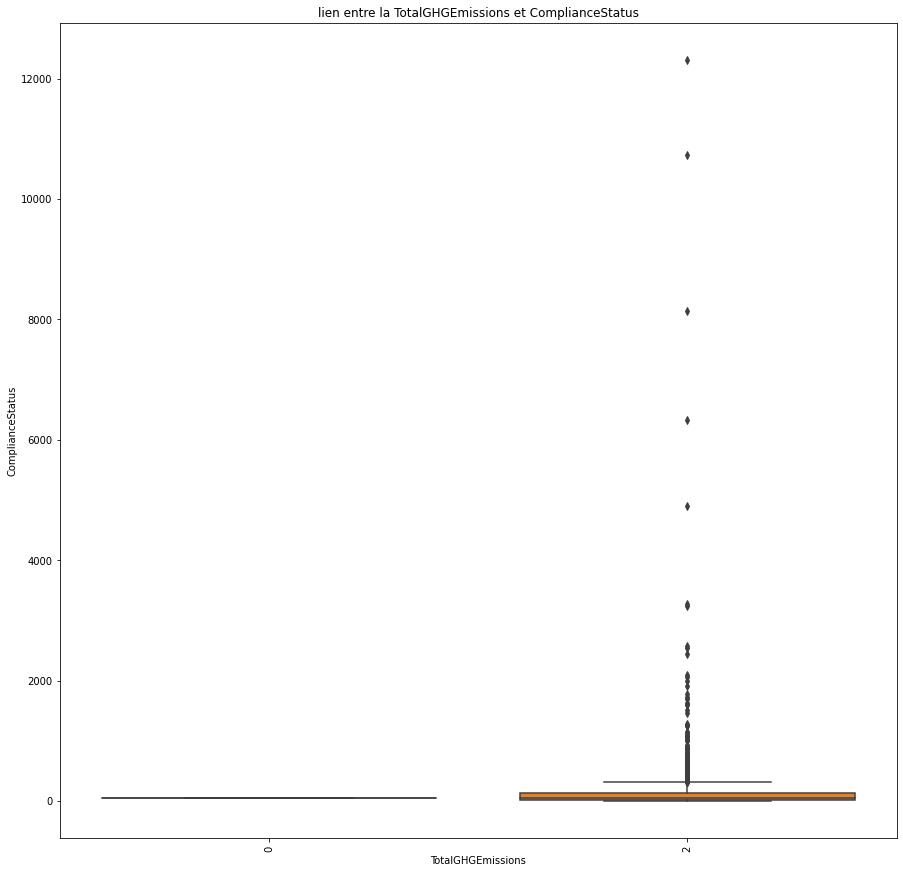

In [ ]:
for i in quan:
   for j in qual1:
      plt.figure(figsize=(15,15))
      sns.boxplot(x=j, y=i, data=df)
      plt.xlabel(i)
      plt.ylabel(j)
      plt.title(f'lien entre la {i} et {j}')
      plt.xticks(rotation=90)
      plt.show()

# Enregistrement du jeu de données

In [ ]:
df.to_csv("batiment.csv")
df1.to_csv("energy_batiment.csv")

In [ ]:
df.shape

(1507, 19)